In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Load the full trainer dataset
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
df = pd.read_csv(pt_path)

# Convert specified columns to numeric and fill missing values with zero
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Define columns for log transformation and direct scaling
log_cols   = ['total_likes', 'videos_count']
scale_cols = ['workout_recommendations', 'athlete_rating', 'years_experience']
scaler     = MinMaxScaler()

# Apply log1p transform then Min–Max scale to skewed features
for c in log_cols:
    df[f'norm_{c}'] = scaler.fit_transform(np.log1p(df[[c]]))

# Apply Min–Max scale directly to remaining features
for c in scale_cols:
    df[f'norm_{c}'] = scaler.fit_transform(df[[c]])

# Use PCA to collapse normalized features into a single score dimension
pca_cols = [f'norm_{c}' for c in (log_cols + scale_cols)]
pca      = PCA(n_components=1).fit(df[pca_cols])
weights  = np.abs(pca.components_[0])
weights /= weights.sum()
df['score'] = df[pca_cols].dot(weights)

# Keep original specialties as strings and lists
df['specialities']    = df['specialities'].astype(str)
df['speciality_list'] = df['specialities'].str.split(',').apply(lambda lst: [s.strip() for s in lst])

# Function to sample trainers with fair coverage of specialties
def sample_with_fair_direction(df_layer, k, used_dirs, seed):
    shuffled = df_layer.sample(frac=1, random_state=seed)
    picked = []
    for _, row in shuffled.iterrows():
        dirs = set(row['speciality_list'])
        if not (dirs & used_dirs):
            picked.append(row)
            used_dirs |= dirs
        if len(picked) == k:
            break
    if len(picked) < k:
        for _, row in shuffled.iterrows():
            if row['trainer_id'] in {t['trainer_id'] for t in picked}:
                continue
            picked.append(row)
            if len(picked) == k:
                break
    return pd.DataFrame(picked), used_dirs

# Function to generate cold-start recommendations for a user
def generate_cold_start_recommendations(all_df, user_id, total_n=18):
    sorted_df = all_df.sort_values('score', ascending=False).reset_index(drop=True)
    n = len(sorted_df)
    layer_size = n // 3
    layers = [
        sorted_df.iloc[:layer_size],
        sorted_df.iloc[layer_size:2*layer_size],
        sorted_df.iloc[2*layer_size:]
    ]
    per_layer = total_n // 3
    used_dirs, samples = set(), []
    for i, layer in enumerate(layers):
        seed = abs(hash(f"{user_id}_{i}")) % (2**32)
        samp, used_dirs = sample_with_fair_direction(layer, per_layer, used_dirs, seed)
        samples.append(samp)
    final_df = pd.concat(samples, ignore_index=True).drop_duplicates('trainer_id')
    return final_df

# Generate synthetic user profiles
age_groups = ['young', 'middle', 'senior']
genders    = ['Male', 'Female']
goal_map   = {
    ('young','Female'): ['Yoga','Pilates','WeightLoss','HIIT','Flexibility','StrengthTraining','Cardio','PrenatalFitness'],
    ('young','Male')  : ['CrossFit','Bodybuilding','Powerlifting','HIIT','Sports-Specific','Cardio','StrengthTraining'],
    ('middle','Female'): ['Pilates','Flexibility','WeightLoss','FunctionalTraining','Yoga','StrengthTraining'],
    ('middle','Male')  : ['StrengthTraining','FunctionalTraining','MuscleBuilding','Sports-Specific','Cardio','HIIT'],
    ('senior','Female'): ['ElderlyFitness','Flexibility','Rehabilitation','Cardio','Pilates','FunctionalTraining'],
    ('senior','Male')  : ['ElderlyFitness','Flexibility','Rehabilitation','FunctionalTraining','Cardio']
}

users = []
for uid in range(10001, 15001):
    age    = random.choice(age_groups)
    gender = random.choice(genders)
    goals  = random.sample(goal_map[(age, gender)], k=random.choices([1, 2], [0.6, 0.4])[0])
    users.append({'user_id': uid, 'age_group': age, 'gender': gender, 'user_goals': ', '.join(goals)})
df_users = pd.DataFrame(users)

# Helper to compute overlap metrics between user goals and trainer specialties
def compute_overlap(goals, specs):
    G = set(goals.split(', '))
    S = set(specs)
    I = G & S
    U = G | S
    return {
        'overlap_count': len(I),
        'jaccard_score': len(I) / len(U) if U else 0.0,
        'direction_match': int(bool(I))
    }

# Function to assign a discrete label based on watch and rating behavior
def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated == 1:
        if score_given == 5:
            return 5
        if score_given == 4:
            return 4
        if score_given == 3:
            return 3
        return 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1


# Simulation parameters
VIDEO_NUM = 5
TRAINERS_PER_USER = 18
alpha     = 0.05   # Increment added to watch probability after each viewed video
p_max     = 0.95   # Maximum watch probability

interactions = []

for _, user in df_users.iterrows():
    picked = generate_cold_start_recommendations(df, user['user_id'], TRAINERS_PER_USER)
    for _, t in picked.iterrows():
        # calculate overlap metrics
        ov = compute_overlap(user['user_goals'], t['speciality_list'])
        
        # simulate watch behavior with linear probability increase
        base_prob = min(0.2 + 0.2 * ov['overlap_count'], p_max)
        watches   = []
        watch_sum = 0
        for _ in range(VIDEO_NUM):
            p_i = min(base_prob + alpha * watch_sum, p_max)
            w   = int(random.random() < p_i)
            watches.append(w)
            watch_sum += w
        
        # simulate rating decision
        if watch_sum >= 2:
            rated_prob = min(0.1 + 0.15 * watch_sum + 0.4 * ov['jaccard_score'], p_max)
            rated      = int(random.random() < rated_prob)
        else:
            rated = 0
        
        # simulate rating value
        if rated == 1:
            raw_score = np.random.normal(
                loc=2.5 + 0.3 * watch_sum + 1.5 * ov['jaccard_score'],
                scale=1.2
            )
            score = int(np.clip(round(raw_score), 1, 5))
        else:
            score = 0
        
        # construct final label
        label = construct_label(watch_sum, rated, score)
        
        # record interaction
        row = {
            **user,
            'trainer_id': t['trainer_id'],
            **{f'watch_v{i+1}': w for i, w in enumerate(watches)},
            'watched_count': watch_sum,
            'rated': rated,
            'score_given': score,
            **ov,
            'athlete_rating': t['athlete_rating'],
            'total_likes': t['total_likes'],
            'videos_count': t['videos_count'],
            'workout_recommendations': t['workout_recommendations'],
            'years_experience': t['years_experience'],
            'label': label
        }
        interactions.append(row)

# Save the synthetic interaction dataset
pd.DataFrame(interactions).to_csv("/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv", index=False)


## User interaction label rules:
### label 0: watched_count == 0
### label 1: watched_count == 1 and rated == 0
### label 2: (rated == 1 and score_given <= 2) or (rated == 0 and watched_count > 1)
### label 3: (rated == 1 and score_given == 3) or (rated == 0 and watched_count > 3)
### label 4: rated == 1 and score_given == 4
### label 5: rated == 1 and score_given == 5

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score

# load interaction data
df = pd.read_csv("/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv")

# split users into train/validation/test (70/15/15)
np.random.seed(42)
user_ids = df['user_id'].unique()
np.random.shuffle(user_ids)
n = len(user_ids)
train_u = set(user_ids[:int(n*0.7)])
val_u   = set(user_ids[int(n*0.7):int(n*0.85)])
test_u  = set(user_ids[int(n*0.85):])

train_df = df[df['user_id'].isin(train_u)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_u)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_u)].reset_index(drop=True)

print("Test dataset label frequency:\n", test_df['label'].value_counts())
print("Whole dataset label frequency:\n", df['label'].value_counts())


Test dataset label frequency:
 label
1    4766
0    4065
2    2779
3     764
4     612
5     514
Name: count, dtype: int64
Whole dataset label frequency:
 label
1    31457
0    27382
2    18361
3     5099
4     4259
5     3442
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.metrics import ndcg_score

# Load and preprocess static trainer data
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
trainers = pd.read_csv(pt_path)
for col in ['athlete_rating', 'total_likes', 'workout_recommendations', 'years_experience', 'videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)

# Fit log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()

# Fit MinMaxScaler for other numeric features
for col in ['workout_recommendations', 'athlete_rating', 'years_experience']:
    trainers[f'{col}_norm'] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# Compute a single static_score via PCA
pca_cols = [
    'total_likes_norm', 'videos_count_norm',
    'workout_recommendations_norm', 'athlete_rating_norm', 'years_experience_norm'
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0])
w /= w.sum()
trainers['static_score'] = trainers[pca_cols].dot(w)

# Prepare specialties as string for overlap calculation
trainers['specialities'] = trainers['specialities'].astype(str)

# Load and merge synthetic interaction data
hist_path = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
df = pd.read_csv(hist_path)
df = df.merge(
    trainers[['trainer_id', 'static_score', 'specialities']],
    on='trainer_id', how='left'
)

# Define functions to compute overlap features
def tokenize(text):
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

def compute_overlap(goals, specs):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), (len(I) / len(U) if U else 0.0), int(bool(I))

ov = df.apply(lambda row: compute_overlap(row['user_goals'], row['specialities']), axis=1).tolist()
df['overlap_count']   = [t[0] for t in ov]
df['jaccard_score']   = [t[1] for t in ov]
df['direction_match'] = [t[2] for t in ov]

# Compute cumulative watch history count per user
df = df.sort_values('user_id').reset_index(drop=True)
df['watch_hist_cnt'] = (
    df.groupby('user_id')['watched_count']
      .apply(lambda s: s.shift().fillna(0).cumsum())
      .reset_index(level=0, drop=True)
)

# Apply the same scalers to interaction data
df['total_likes_norm']  = scaler_likes.transform(np.log1p(df[['total_likes']])).ravel()
df['videos_count_norm'] = scaler_videos.transform(np.log1p(df[['videos_count']])).ravel()

scaler_wr     = MinMaxScaler().fit(trainers[['workout_recommendations']])
scaler_rating = MinMaxScaler().fit(trainers[['athlete_rating']])
scaler_exp    = MinMaxScaler().fit(trainers[['years_experience']])

df['workout_recommendations_norm'] = scaler_wr.transform(df[['workout_recommendations']]).ravel()
df['athlete_rating_norm']          = scaler_rating.transform(df[['athlete_rating']]).ravel()
df['years_experience_norm']        = scaler_exp.transform(df[['years_experience']]).ravel()

# Filter to users with at least one positive label
valid_users = df.groupby('user_id')['label'].max().loc[lambda x: x > 0].index
df = df[df['user_id'].isin(valid_users)].reset_index(drop=True)

# Define feature columns, label, and grouping column
feature_cols = [
    'watch_hist_cnt',
    'athlete_rating_norm', 'total_likes_norm', 'videos_count_norm',
    'workout_recommendations_norm', 'years_experience_norm',
    'static_score'
]
label_col = 'label'
group_col = 'user_id'

# Set up grid search over key hyperparameters
grid_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'min_data_in_leaf': [20, 50, 100]
}
ndcg_at = [5, 10, 15]

results = []
gkf = GroupKFold(n_splits=5)

# Perform grid search with GroupKFold cross-validation
for params in ParameterGrid(grid_params):
    params_full = {
        **params,
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': ndcg_at,
        'verbose': -1
    }
    fold_scores = {k: [] for k in ndcg_at}
    
    for train_idx, val_idx in gkf.split(df, df[label_col], groups=df[group_col]):
        tr, va = df.iloc[train_idx], df.iloc[val_idx]
        dtr = lgb.Dataset(
            tr[feature_cols],
            label=tr[label_col],
            group=tr.groupby(group_col).size().tolist()
        )
        dva = lgb.Dataset(
            va[feature_cols],
            label=va[label_col],
            group=va.groupby(group_col).size().tolist(),
            reference=dtr
        )
        model = lgb.train(
            params_full,
            dtr,
            valid_sets=[dva],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=0)
            ]
        )
        
        for k in ndcg_at:
            scores = []
            for _, grp in va.groupby(group_col):
                if len(grp) > 1:
                    pred = model.predict(grp[feature_cols], num_iteration=model.best_iteration)
                    scores.append(ndcg_score([grp[label_col].values], [pred], k=k))
            fold_scores[k].append(np.mean(scores))
    
    row = params.copy()
    for k in ndcg_at:
        row[f'NDCG@{k}'] = np.mean(fold_scores[k])
    results.append(row)

# Create and print results table
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's ndcg@5: 0.33247	valid_0's ndcg@10: 0.44424	valid_0's ndcg@15: 0.537687
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's ndcg@5: 0.332729	valid_0's ndcg@10: 0.446121	valid_0's ndcg@15: 0.539855
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's ndcg@5: 0.327251	valid_0's ndcg@10: 0.435016	valid_0's ndcg@15: 0.534137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's ndcg@5: 0.32749	valid_0's ndcg@10: 0.443652	valid_0's ndcg@15: 0.537951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's ndcg@5: 0.323641	valid_0's ndcg@10: 0.44291	valid_0's ndcg@15: 0.537272
Training until validation scores don't improve for 50 round

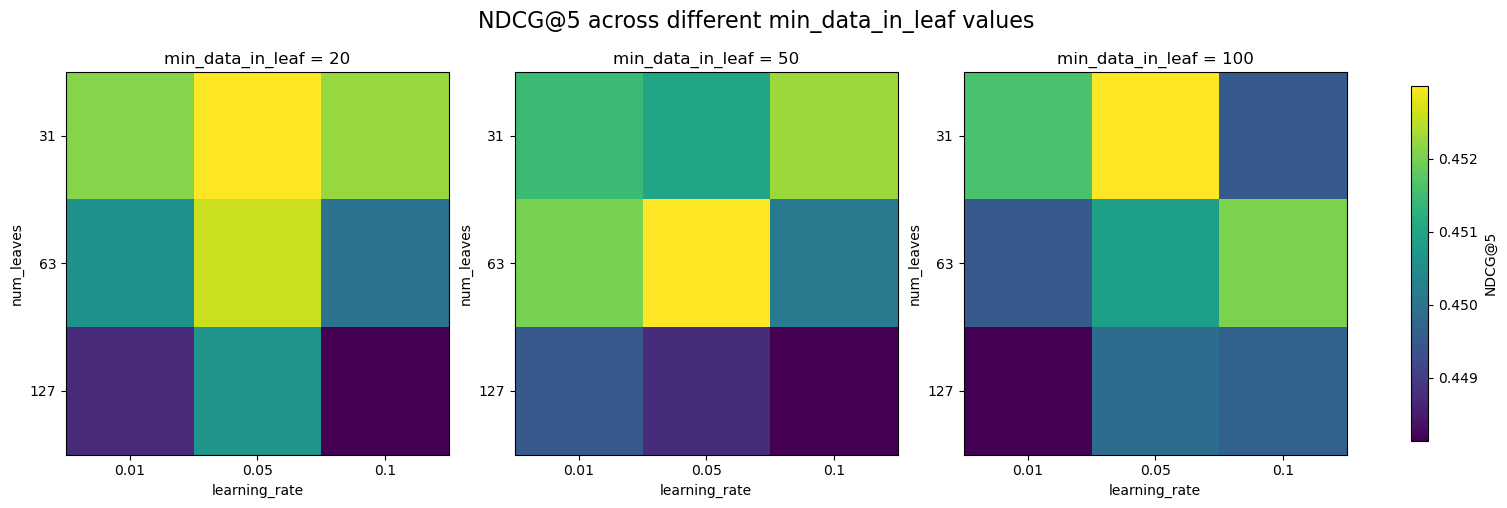

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure df_results is defined; if not, load:
# df_results = pd.read_csv("grid_search_results.csv")

metric = 'NDCG@5'
min_leaves = sorted(df_results['min_data_in_leaf'].unique())
n = len(min_leaves)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), constrained_layout=True)
# Make axes iterable
if not isinstance(axes, (np.ndarray, list)):
    axes = [axes]

for ax, min_leaf in zip(axes, min_leaves):
    df_sub = df_results[df_results['min_data_in_leaf'] == min_leaf]
    pivot = df_sub.pivot(index='num_leaves', columns='learning_rate', values=metric)
    
    im = ax.imshow(pivot)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('learning_rate')
    ax.set_ylabel('num_leaves')
    ax.set_title(f'min_data_in_leaf = {min_leaf}')

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8)
cbar.set_label(metric)

plt.suptitle('NDCG@5 across different min_data_in_leaf values', fontsize=16)
plt.show()


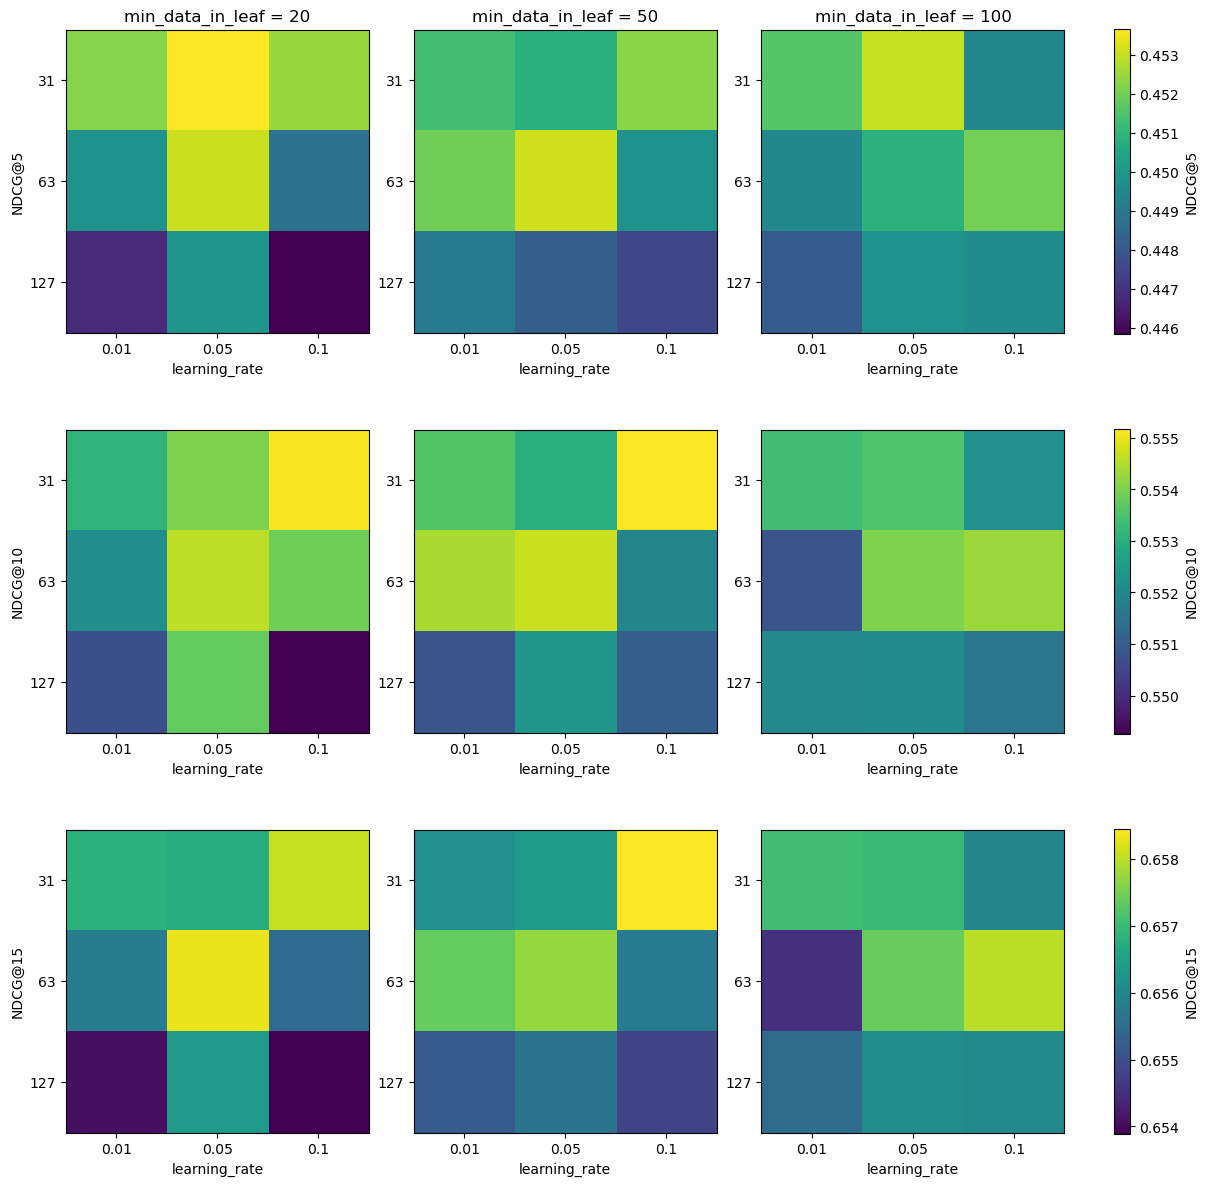

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your results if not already in memory:
# df_results = pd.read_csv("grid_search_results.csv")

metrics = ['NDCG@5', 'NDCG@10', 'NDCG@15']
min_leaf_vals = sorted(df_results['min_data_in_leaf'].unique())
num_rows = len(metrics)
num_cols = len(min_leaf_vals)

fig, axes = plt.subplots(num_rows, num_cols,
                         figsize=(4 * num_cols, 4 * num_rows),
                         constrained_layout=True)

# Ensure axes is 2D array even if num_rows or num_cols == 1
axes = np.atleast_2d(axes)

for i, metric in enumerate(metrics):
    # compute vmin/vmax just for this metric across all leaf settings
    vals = df_results[metric].values
    vmin, vmax = vals.min(), vals.max()
    
    for j, min_leaf in enumerate(min_leaf_vals):
        ax = axes[i, j]
        df_sub = df_results[df_results['min_data_in_leaf'] == min_leaf]
        pivot = df_sub.pivot(index='num_leaves',
                             columns='learning_rate',
                             values=metric)
        
        im = ax.imshow(pivot, vmin=vmin, vmax=vmax)
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)
        if i == 0:
            ax.set_title(f'min_data_in_leaf = {min_leaf}')
        if j == 0:
            ax.set_ylabel(metric)
        ax.set_xlabel('learning_rate')
    
    # one colorbar per row
    cbar = fig.colorbar(im, ax=axes[i, :], orientation='vertical', shrink=0.8)
    cbar.set_label(metric)

plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/NDCG Performance Spectrum.pdf")
plt.show()


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

# 1. Load & preprocess trainer static data
pt_path = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
trainers = pd.read_csv(pt_path)
for c in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[c] = pd.to_numeric(trainers[c], errors='coerce').fillna(0)

#  Fit separate log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))

trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()

#  Scale other numeric features independently
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()

#  Compute a static PCA score
pca_cols = [
    'total_likes_norm','videos_count_norm',
    'workout_recommendations_norm','athlete_rating_norm','years_experience_norm'
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[pca_cols].dot(w)

trainers['specialities'] = trainers['specialities'].astype(str)


# 2. Load synthetic interactions and merge in only static_score + specialities
hist_path = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
df = pd.read_csv(hist_path)
df = df.merge(
    trainers[['trainer_id','static_score','specialities']],
    on='trainer_id', how='left'
)


# 3. Helper functions for dynamic features
def tokenize(text):
    return {tok.strip().lower() for tok in re.split(r'[,;/、]', text) if tok.strip()}

def compute_overlap(goals, specs):
    G = tokenize(goals); S = tokenize(specs)
    I = G & S; U = G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))


# 4. Compute dynamic features
df = df.reset_index(drop=True)
ov = df.apply(lambda r: compute_overlap(r['user_goals'], r['specialities']), axis=1).tolist()
df['overlap_count']   = [t[0] for t in ov]
df['jaccard_score']   = [t[1] for t in ov]
df['direction_match'] = [t[2] for t in ov]

df = df.sort_values(['user_id']).reset_index(drop=True)
df['watch_hist_cnt'] = (
    df.groupby('user_id')['watched_count']
      .apply(lambda s: s.shift().fillna(0).cumsum())
      .reset_index(level=0, drop=True)
)


# 5. Re‑apply the exact count‑feature scaling used at inference
df['total_likes']  = scaler_likes.transform(np.log1p(df[['total_likes']])).ravel()
df['videos_count'] = scaler_videos.transform(np.log1p(df[['videos_count']])).ravel()

# 6. Filter out users with no positive labels
valid_users = df.groupby('user_id')['label'].max().loc[lambda x: x>0].index
df = df[df['user_id'].isin(valid_users)].reset_index(drop=True)

# 7. Define features, label & grouping
feature_cols = [
    'watch_hist_cnt',
    'athlete_rating','total_likes','videos_count',
    'workout_recommendations','years_experience',
    'static_score'
]
label_col = 'label'
group_col = 'user_id'

def make_group(dd):
    return dd.groupby(group_col).size().tolist()


# 8. 5‑fold GroupKFold CV + LambdaRank (using callbacks for early stop)
gkf = GroupKFold(n_splits=5)
ndcg_at = [5, 10, 15]
fold_ndcg = {k: [] for k in ndcg_at}
fold_map = []

for train_idx, val_idx in gkf.split(df, groups=df[group_col]):
    tr = df.iloc[train_idx].reset_index(drop=True)
    va = df.iloc[val_idx].reset_index(drop=True)

    dtr = lgb.Dataset(tr[feature_cols], label=tr[label_col], group=make_group(tr))
    dva = lgb.Dataset(va[feature_cols], label=va[label_col], group=make_group(va), reference=dtr)

    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': ndcg_at,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 50,
        'verbose': -1
    }

    model = lgb.train(
        params,
        dtr,
        num_boost_round=500,
        valid_sets=[dva],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50)
        ]
    )

    va['pred'] = model.predict(va[feature_cols])

    # NDCG
    for k in ndcg_at:
        scs = []
        for _, grp in va.groupby(group_col):
            y_t = grp[label_col].values.reshape(1,-1)
            y_p = grp['pred'].values.reshape(1,-1)
            if y_t.size>1:
                scs.append(ndcg_score(y_t, y_p, k=k))
        fold_ndcg[k].append(np.mean(scs))

    # MAP
    maps = []
    for _, grp in va.groupby(group_col):
        y_bin = (grp[label_col]>0).astype(int)
        if y_bin.sum()>0:
            maps.append(average_precision_score(y_bin, grp['pred'].values))
    fold_map.append(np.mean(maps) if maps else 0.0)


# 9. Print CV results
for k in ndcg_at:
    print(f"CV NDCG@{k}: {np.mean(fold_ndcg[k]):.4f} ± {np.std(fold_ndcg[k]):.4f}")
print(f"CV MAP: {np.mean(fold_map):.4f} ± {np.std(fold_map):.4f}")

# 10. Build plotting DataFrame
metrics = ['NDCG@5', 'NDCG@10', 'NDCG@15', 'MAP']
scores  = fold_ndcg[5] + fold_ndcg[10] + fold_ndcg[15] + fold_map
folds   = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'] * 4

df_plot = pd.DataFrame({
    'Metric': ['NDCG@5']*5 + ['NDCG@10']*5 + ['NDCG@15']*5 + ['MAP']*5,
    'Score': scores,
    'Fold': folds
})

# train on all data & save model
dall = lgb.Dataset(df[feature_cols], label=df[label_col], group=make_group(df))
final_model = lgb.train(params, dall, num_boost_round=model.best_iteration)
final_model.save_model("/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.324369	valid_0's ndcg@10: 0.447485	valid_0's ndcg@15: 0.539218
Early stopping, best iteration is:
[10]	valid_0's ndcg@5: 0.328245	valid_0's ndcg@10: 0.444753	valid_0's ndcg@15: 0.535751
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.327611	valid_0's ndcg@10: 0.443935	valid_0's ndcg@15: 0.538254
[100]	valid_0's ndcg@5: 0.333045	valid_0's ndcg@10: 0.450238	valid_0's ndcg@15: 0.54309
Early stopping, best iteration is:
[80]	valid_0's ndcg@5: 0.334605	valid_0's ndcg@10: 0.450312	valid_0's ndcg@15: 0.544416
Training until validation scores don't improve for 50 rounds
[50]	valid_0's ndcg@5: 0.318098	valid_0's ndcg@10: 0.43762	valid_0's ndcg@15: 0.532514
[100]	valid_0's ndcg@5: 0.324875	valid_0's ndcg@10: 0.443889	valid_0's ndcg@15: 0.538106
Early stopping, best iteration is:
[83]	valid_0's ndcg@5: 0.327616	valid_0's ndcg@10: 0.44056	valid_0's ndcg@15: 0.536185
Training 

### Visualization of Cross-Validation Metric Distributions with Fold Scores & Mean

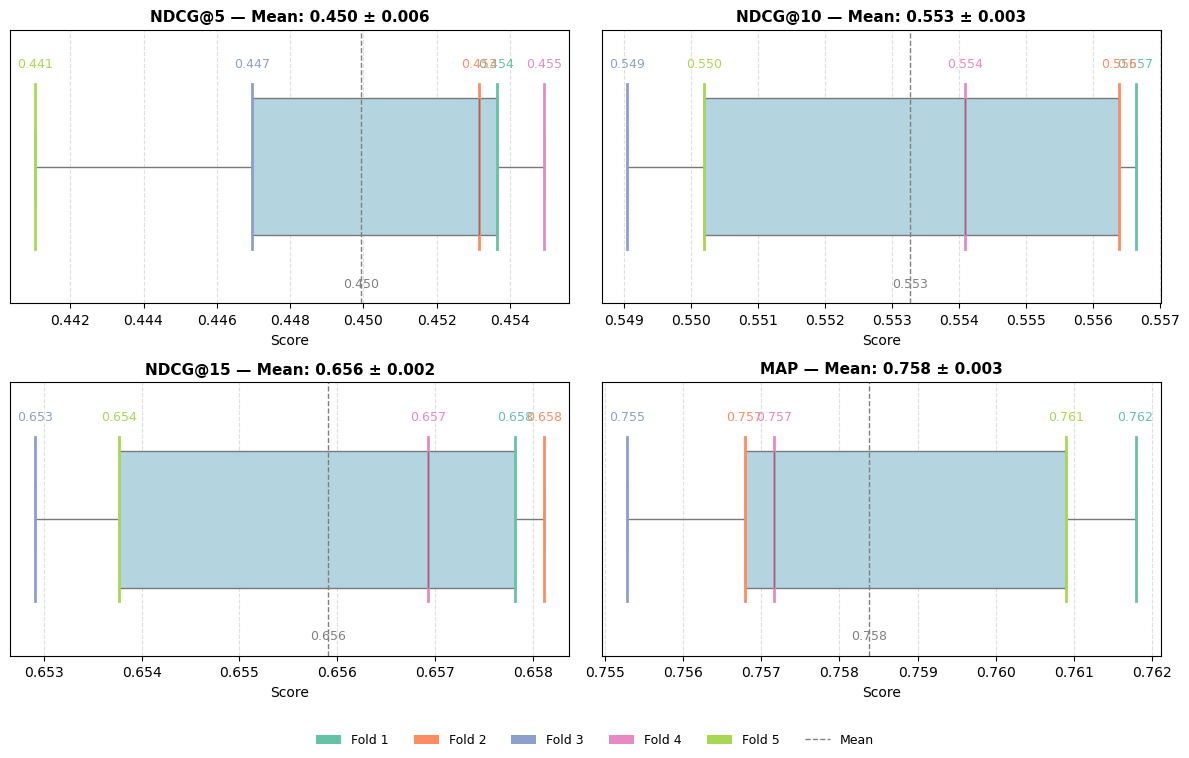

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Prepare data: columns = ['Metric', 'Score', 'Fold']
df = df_plot
metrics = ['NDCG@5', 'NDCG@10', 'NDCG@15', 'MAP']
fold_colors = sns.color_palette("Set2", n_colors=5)
fold_names  = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    df_m = df[df['Metric'] == metric]
    ax = axes[i]

    # Boxplot
    sns.boxplot(data=df_m, x='Score', color='lightblue', ax=ax, width=0.5, fliersize=0)

    # Count how many folds have identical (rounded) score
    score_counts = df_m['Score'].round(5).value_counts()

    # Draw each fold’s score as vertical line
    for _, row in df_m.iterrows():
        fold_idx = int(row['Fold'][-1]) - 1
        score = row['Score']
        score_r = round(score, 5)
        lw = 4 if score_counts[score_r] > 1 else 2  # Thicker line if score is duplicated

        # Draw line
        ax.axvline(x=score, color=fold_colors[fold_idx], ymin=0.2, ymax=0.8, linewidth=lw)

        # Draw score text
        ax.text(score, 0.85, f"{score:.3f}", fontsize=9, color=fold_colors[fold_idx],
                ha='center', va='bottom', transform=ax.get_xaxis_transform())

    # Draw mean line and label
    mean = df_m['Score'].mean()
    std  = df_m['Score'].std()
    ax.axvline(x=mean, color='gray', linestyle='--', linewidth=1)
    ax.text(mean, 0.05, f"{mean:.3f}", fontsize=9, color='gray',
            ha='center', va='bottom', transform=ax.get_xaxis_transform())

    # Title and formatting
    ax.set_title(f"{metric} — Mean: {mean:.3f} ± {std:.3f}", fontsize=11, fontweight='bold')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.4)

# Custom legend (folds + mean)
legend_elements = [Patch(facecolor=fold_colors[i], edgecolor='none', label=fold_names[i]) for i in range(5)]
legend_elements.append(Line2D([0], [0], color='gray', linestyle='--', linewidth=1, label='Mean'))
fig.legend(handles=legend_elements, loc='lower center', ncol=6, frameon=False, fontsize=9)

# Layout
# plt.suptitle("Cross-Validation Metric Distributions with Fold Scores & Mean", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Cross-Validation Metric Distributions with Fold Scores & Mean.pdf", bbox_inches='tight')
plt.show()


In [51]:
import lightgbm as lgb
bst = lgb.Booster(model_file="/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt")
print(bst.feature_name())

['watch_hist_cnt', 'athlete_rating', 'total_likes', 'videos_count', 'workout_recommendations', 'years_experience', 'static_score']


## Example ranking of User 10001 based on LambdaRank model and SHAP evaluation

In [97]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1. Paths & parameters
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
USER_ID    = 10001
TOP_N      = 30

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for c in ["athlete_rating","total_likes","workout_recommendations","years_experience","videos_count"]:
    trainers[c] = pd.to_numeric(trainers[c], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Fit log1p + MinMaxScalers on count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# 4. Build normalized columns for PCA
trainers["total_likes_norm"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]])).ravel()
for c in ["workout_recommendations","athlete_rating","years_experience"]:
    trainers[f"{c}_norm"] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()

# 5. Compute static_score via PCA
pca_cols = [
    "total_likes_norm","videos_count_norm",
    "workout_recommendations_norm","athlete_rating_norm","years_experience_norm"
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers["static_score"] = trainers[pca_cols].dot(w)

# 6. Load user interaction history
history = pd.read_csv(HIST_PATH)
user_hist = history[history["user_id"]==USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user {USER_ID}")

# 7. Prepare full candidate pool
cands = trainers.copy()

# 8. Dynamic feature helpers
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))

# 9. Compute overlap metrics
goals = user_hist["user_goals"].iloc[0]
ov = cands["specialities"].apply(lambda s: compute_overlap(goals, s)).tolist()
cands["overlap_count"]   = [t[0] for t in ov]
cands["jaccard_score"]   = [t[1] for t in ov]
cands["direction_match"] = [t[2] for t in ov]

# 10. Compute watch history count per trainer
watch_map = user_hist.groupby("trainer_id")["watched_count"].sum().to_dict()
cands["watch_hist_cnt"] = cands["trainer_id"].map(watch_map).fillna(0).astype(int)

# 11. Re-apply exact count scaling (log1p + MinMax) for inference
cands["total_likes"]  = scaler_likes.transform(np.log1p(cands[["total_likes"]])).ravel()
cands["videos_count"] = scaler_videos.transform(np.log1p(cands[["videos_count"]])).ravel()

# 12. Load the LambdaRank model
ranker = lgb.Booster(model_file=MODEL_PATH)

# 13. Ensure feature order matches training
feature_cols = [
    "watch_hist_cnt",
    "athlete_rating","total_likes","videos_count",
    "workout_recommendations","years_experience","static_score"
]

# 14. Predict and build composite with interest-aware static score
# 14.1 Predict model score
cands["pred_score"] = ranker.predict(cands[feature_cols].values)

# 14.2 Normalize features
scaler_pred     = MinMaxScaler().fit(cands[["pred_score"]])
scaler_overlap  = MinMaxScaler().fit(cands[["overlap_count"]])
scaler_jaccard  = MinMaxScaler().fit(cands[["jaccard_score"]])
scaler_static   = MinMaxScaler().fit(cands[["static_score"]])

cands["pred_norm"]      = scaler_pred.transform(cands[["pred_score"]]).ravel()
cands["overlap_norm"]   = scaler_overlap.transform(cands[["overlap_count"]]).ravel()
cands["jaccard_norm"]   = scaler_jaccard.transform(cands[["jaccard_score"]]).ravel()
cands["static_norm"]    = scaler_static.transform(cands[["static_score"]]).ravel()

# 14.3 Compose interest-aware static score
# 40% static + 30% overlap + 30% jaccard
cands["static_with_interest"] = (
      cands["static_norm"] * 0.4
    + cands["overlap_norm"] * 0.3
    + cands["jaccard_norm"] * 0.3
)

# 14.4 Final composite score: 80% model + 20% interest-static
cands["composite_score"] = (
      cands["pred_norm"] * 0.8
    + MinMaxScaler().fit_transform(cands[["static_with_interest"]]).ravel() * 0.2
)

# 15. Output final Top-N by composite_score
topN = cands.nlargest(TOP_N, "composite_score")
print(
    topN[[
        "trainer_id","pred_score","static_score",
        "static_with_interest","composite_score","direction_match"
    ]].reset_index(drop=True)
)


    trainer_id  pred_score  static_score  static_with_interest  \
0          425    0.522757      0.245806              0.528083   
1          338    0.615521      0.358800              0.130580   
2          801    0.535598      0.240865              0.075787   
3          525    0.498216      0.431085              0.164164   
4          677    0.426173      0.850230              0.358900   
5          340    0.264289      0.834181              0.951444   
6           83    0.275973      0.774565              0.723746   
7          184    0.311411      0.367309              0.534533   
8          175    0.249520      0.727479              0.751870   
9          901    0.289074      0.345851              0.524564   
10         287    0.218128      0.704475              0.691182   
11         480    0.183568      0.522177              0.806486   
12         988    0.263277      0.255951              0.482796   
13         905    0.259035      0.253035              0.481441   
14        

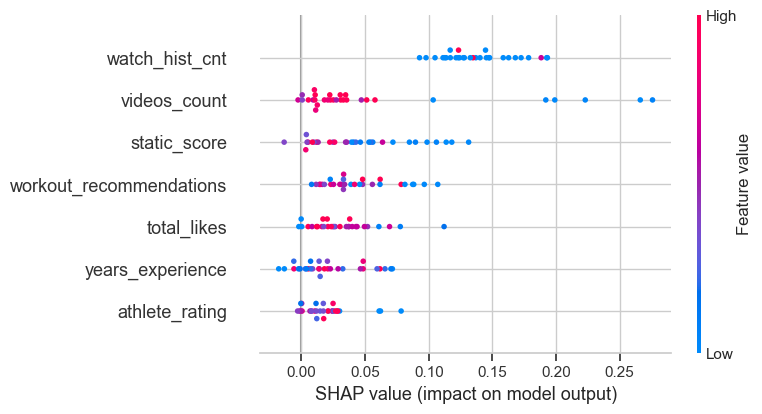

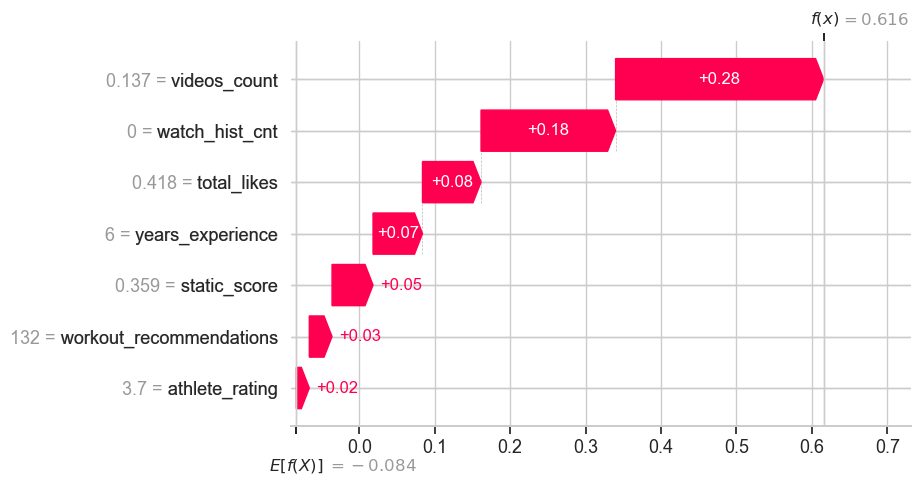

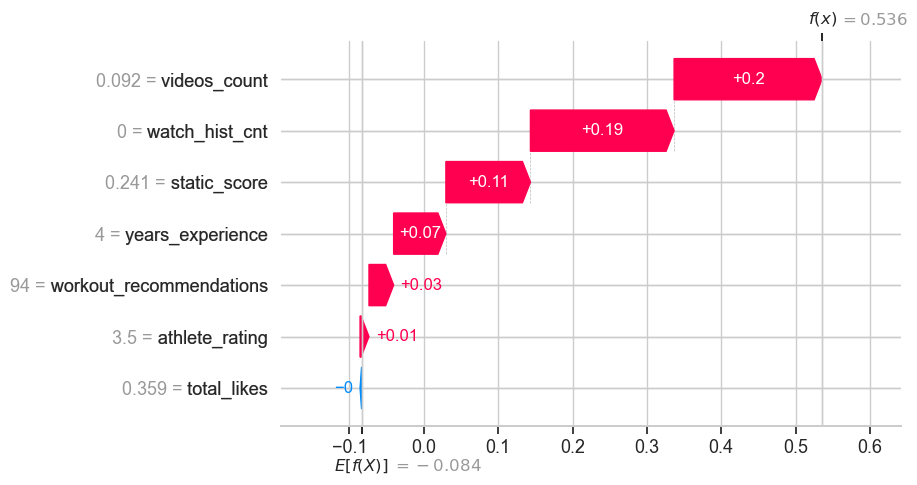

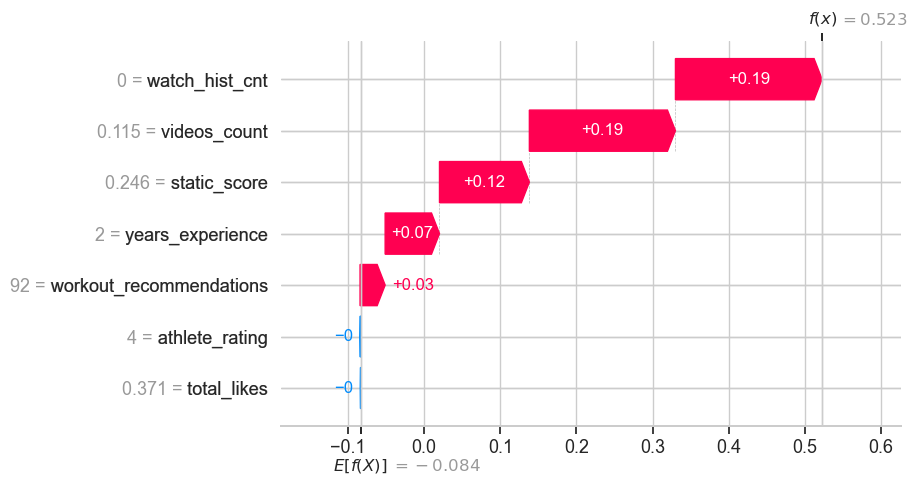

  0%|          | 0/30 [00:00<?, ?it/s]

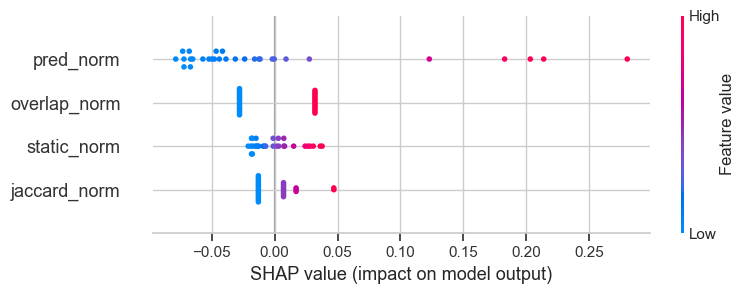

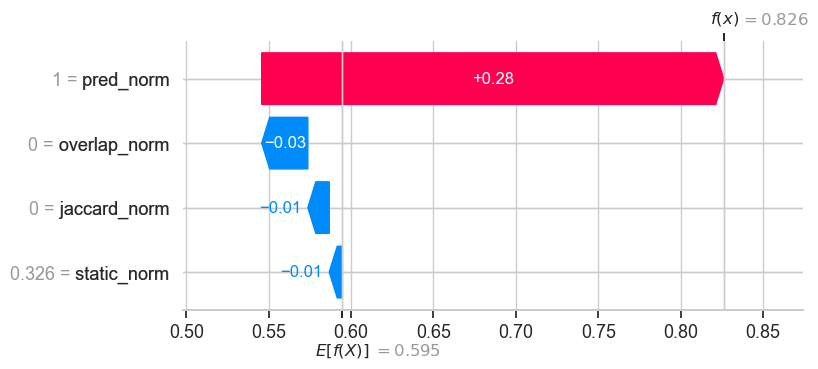

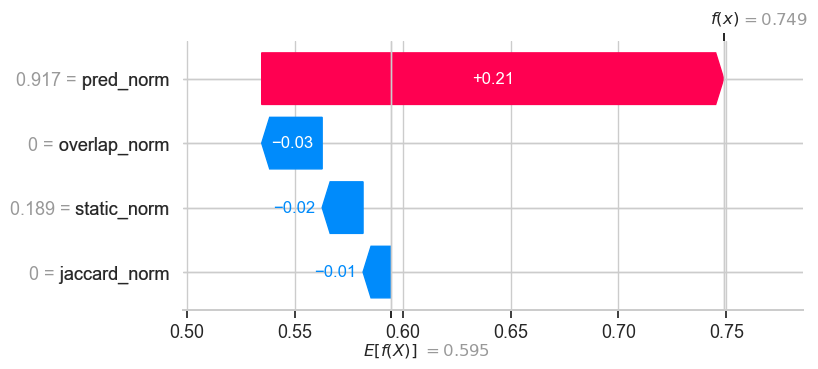

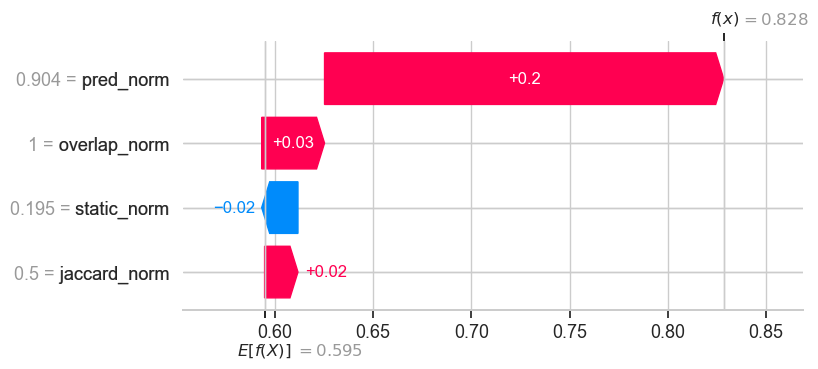

In [50]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Configuration & paths
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
USER_ID    = 10001
TOP_N      = 30
rng = np.random.default_rng(42)

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for col in [
    "athlete_rating",
    "total_likes",
    "workout_recommendations",
    "years_experience",
    "videos_count",
]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Fit log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# 4. Build normalized columns for PCA
trainers["total_likes_norm"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]])).ravel()
for col in ["workout_recommendations", "athlete_rating", "years_experience"]:
    trainers[f"{col}_norm"] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# 5. Compute static PCA score
pca_cols = [
    "total_likes_norm",
    "videos_count_norm",
    "workout_recommendations_norm",
    "athlete_rating_norm",
    "years_experience_norm",
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers["static_score"] = trainers[pca_cols].dot(w)

# 6. Load user history & build candidate pool
history = pd.read_csv(HIST_PATH)
user_hist = history[history["user_id"] == USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user_id={USER_ID}")
cands = trainers.copy()

# 7. Compute dynamic features
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))

goals = user_hist["user_goals"].iloc[0]
ov = cands["specialities"].apply(lambda s: compute_overlap(goals, s)).tolist()
cands["overlap_count"]   = [t[0] for t in ov]
cands["jaccard_score"]   = [t[1] for t in ov]
cands["watch_hist_cnt"]  = cands["trainer_id"].map(
    user_hist.groupby("trainer_id")["watched_count"].sum()
).fillna(0).astype(int)

# 8. Re‑apply count feature scaling
cands["total_likes"]  = scaler_likes.transform(np.log1p(cands[["total_likes"]])).ravel()
cands["videos_count"] = scaler_videos.transform(np.log1p(cands[["videos_count"]])).ravel()

# 9. Compute interest-aware static score
# Normalize within pool
minmax = MinMaxScaler()
cands[["overlap_norm", "jaccard_norm", "static_norm"]] = minmax.fit_transform(
    cands[["overlap_count", "jaccard_score", "static_score"]]
)
# Compose: 40% static + 30% overlap + 30% jaccard
cands["static_with_interest"] = (
      cands["static_norm"] * 0.4
    + cands["overlap_norm"] * 0.3
    + cands["jaccard_norm"] * 0.3
)

# 10. Load and predict with LambdaRank model
ranker = lgb.Booster(model_file=MODEL_PATH)
feature_cols = [
    "watch_hist_cnt",
    "athlete_rating","total_likes","videos_count",
    "workout_recommendations","years_experience","static_score"
]
cands["pred_score"] = ranker.predict(cands[feature_cols].values)

# 11. Normalize pred_score & static_with_interest globally
scaler_pred = MinMaxScaler().fit(cands[["pred_score"]])
scaler_si   = MinMaxScaler().fit(cands[["static_with_interest"]])
cands["pred_norm"]               = scaler_pred.transform(cands[["pred_score"]]).ravel()
cands["static_with_interest_norm"] = scaler_si.transform(cands[["static_with_interest"]]).ravel()

# 12. Select Top-N for explanation
topN = cands.nlargest(TOP_N, "pred_score").reset_index(drop=True)

# 13. SHAP explanation on model's pred_score (as before)
explainer_model = shap.TreeExplainer(ranker)
shap_vals_model = explainer_model.shap_values(topN[feature_cols])

plt.figure(figsize=(10,6))
shap.summary_plot(shap_vals_model, topN[feature_cols], feature_names=feature_cols, show=True, rng=rng)

for i in range(min(3, len(shap_vals_model))):
    plt.figure(figsize=(10,4))
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_model[i],
            base_values=explainer_model.expected_value,
            data=topN[feature_cols].iloc[i],
            feature_names=feature_cols
        ),
        show=True
    )

# 14. SHAP-like explanation for composite_score via KernelExplainer
alpha_pred     = 0.8
alpha_interest = 0.2
static_w, overlap_w, jaccard_w = 0.4, 0.3, 0.3

# Prepare composite feature matrix
comp_feats = topN[["pred_norm","static_norm","overlap_norm","jaccard_norm"]]
# Define composite function for explainer
def composite_fn(X):
    # X columns: pred_norm, static_norm, overlap_norm, jaccard_norm
    return (
        alpha_pred * X[:,0]
        + alpha_interest * (static_w * X[:,1] + overlap_w * X[:,2] + jaccard_w * X[:,3])
    )

# Use a small background sample
background = comp_feats.sample(n=min(50, len(comp_feats)), random_state=42).values
explainer_comp = shap.KernelExplainer(composite_fn, background)
shap_vals_comp = explainer_comp.shap_values(comp_feats.values)

# Summary plot for composite contributions
plt.figure(figsize=(8,5))
shap.summary_plot(
    shap_vals_comp,
    comp_feats,
    feature_names=["pred_norm","static_norm","overlap_norm","jaccard_norm"],
    show=True,
    rng=rng
)

# Waterfall for first three composite instances
for i in range(min(3, len(shap_vals_comp))):
    plt.figure(figsize=(8,4))
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_comp[i],
            base_values=explainer_comp.expected_value,
            data=comp_feats.iloc[i].values,
            feature_names=["pred_norm","static_norm","overlap_norm","jaccard_norm"]
        ),
        show=True
    )



  0%|          | 0/20 [00:00<?, ?it/s]

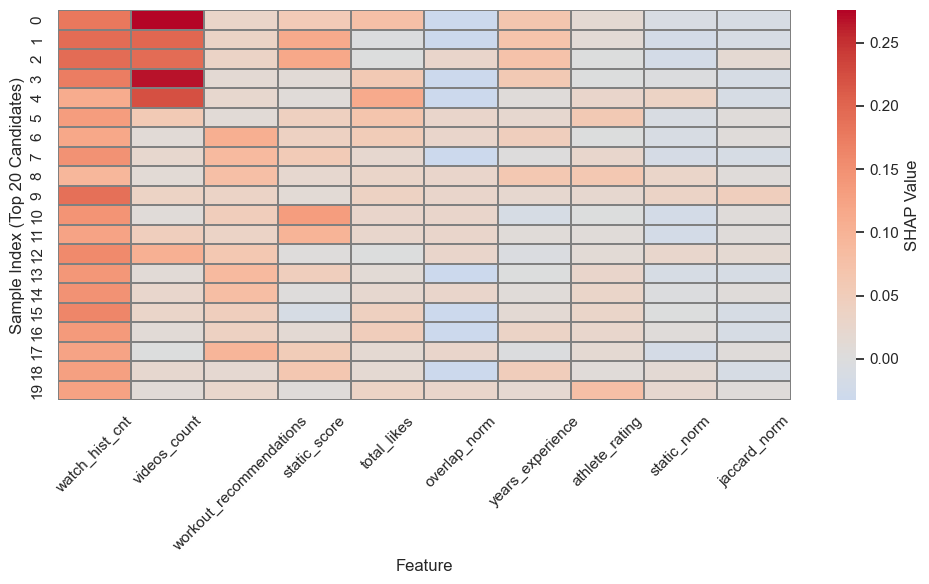

In [79]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Top 20 candidates from model prediction
HEATMAP_TOP_K = 20
top_df = cands.nlargest(HEATMAP_TOP_K, "pred_score").reset_index(drop=True)
heatmap_df_model = top_df[feature_cols].reset_index(drop=True)
heatmap_df_comp  = top_df[["static_norm", "overlap_norm", "jaccard_norm"]].reset_index(drop=True)

# Model SHAP values
explainer_model = shap.TreeExplainer(ranker)
shap_vals_model = explainer_model.shap_values(heatmap_df_model)

# Composite SHAP values
comp_feats = top_df[["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]]
background = comp_feats.sample(n=min(50, len(comp_feats)), random_state=42).values
explainer_comp = shap.KernelExplainer(composite_fn, background)
shap_vals_comp = explainer_comp.shap_values(comp_feats.values)
shap_vals_comp_part = shap_vals_comp[:, 1:]  # 去掉 pred_norm，对应 static/overlap/jaccard

# Construct SHAP DataFrame
shap_df_model = pd.DataFrame(shap_vals_model, columns=feature_cols)
shap_df_comp  = pd.DataFrame(shap_vals_comp_part, columns=["static_norm", "overlap_norm", "jaccard_norm"])
shap_df_full  = pd.concat([shap_df_model, shap_df_comp], axis=1)

# Serial order by mean absolute value
col_order = shap_df_full.abs().mean().sort_values(ascending=False).index.tolist()
shap_df_full = shap_df_full[col_order]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    shap_df_full,
    cmap="coolwarm", center=0,
    linewidths=0.1, linecolor='gray',
    annot=False,
    cbar_kws={'label': 'SHAP Value'}
)
plt.xticks(rotation=45)
plt.xlabel("Feature")
plt.ylabel("Sample Index (Top 20 Candidates)")
# plt.title("SHAP Contributions of LambdaRank & Composite Features (User 10001)")
plt.tight_layout()
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/SHAP Contributions of LambdaRank & Composite Features (User 10001).pdf", format="pdf", bbox_inches="tight")
plt.show()


In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuration & paths
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
PLOT_DIR   = "/Users/cailingchen/Desktop/Final Project/Plots/"
USER_ID    = 10001
TOP_N      = 30
rng = np.random.default_rng(42)

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for col in [
    "athlete_rating", "total_likes", "workout_recommendations",
    "years_experience", "videos_count",
]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Fit log1p + MinMaxScaler for count features
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))

# 4. Build normalized columns for PCA
trainers["total_likes_norm"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]])).ravel()
trainers["videos_count_norm"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]])).ravel()
for col in ["workout_recommendations", "athlete_rating", "years_experience"]:
    trainers[f"{col}_norm"] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# 5. Compute static PCA score
pca_cols = [
    "total_likes_norm", "videos_count_norm",
    "workout_recommendations_norm", "athlete_rating_norm", "years_experience_norm",
]
pca = PCA(n_components=1).fit(trainers[pca_cols])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers["static_score"] = trainers[pca_cols].dot(w)

# 6. Load user history & build candidate pool
history = pd.read_csv(HIST_PATH)
user_hist = history[history["user_id"] == USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user_id={USER_ID}")
cands = trainers.copy()

# 7. Compute dynamic features
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), (len(I)/len(U) if U else 0.0), int(bool(I))

goals = user_hist["user_goals"].iloc[0]
ov = cands["specialities"].apply(lambda s: compute_overlap(goals, s)).tolist()
cands["overlap_count"]   = [t[0] for t in ov]
cands["jaccard_score"]   = [t[1] for t in ov]
cands["watch_hist_cnt"]  = cands["trainer_id"].map(
    user_hist.groupby("trainer_id")["watched_count"].sum()
).fillna(0).astype(int)

# 8. Re-apply count feature scaling
cands["total_likes"]  = scaler_likes.transform(np.log1p(cands[["total_likes"]])).ravel()
cands["videos_count"] = scaler_videos.transform(np.log1p(cands[["videos_count"]])).ravel()

# 9. Compute interest-aware static score
minmax = MinMaxScaler()
cands[["overlap_norm", "jaccard_norm", "static_norm"]] = minmax.fit_transform(
    cands[["overlap_count", "jaccard_score", "static_score"]]
)
cands["static_with_interest"] = (
    cands["static_norm"] * 0.4 +
    cands["overlap_norm"] * 0.3 +
    cands["jaccard_norm"] * 0.3
)

# 10. Load and predict with LambdaRank model
ranker = lgb.Booster(model_file=MODEL_PATH)
feature_cols = [
    "watch_hist_cnt", "athlete_rating", "total_likes", "videos_count",
    "workout_recommendations", "years_experience", "static_score"
]
cands["pred_score"] = ranker.predict(cands[feature_cols].values)

# 11. Normalize scores
scaler_pred = MinMaxScaler().fit(cands[["pred_score"]])
scaler_si   = MinMaxScaler().fit(cands[["static_with_interest"]])
cands["pred_norm"]               = scaler_pred.transform(cands[["pred_score"]]).ravel()
cands["static_with_interest_norm"] = scaler_si.transform(cands[["static_with_interest"]]).ravel()

# 12. Select Top-N
topN = cands.nlargest(TOP_N, "pred_score").reset_index(drop=True)

# 13. SHAP explanation on model's pred_score
explainer_model = shap.TreeExplainer(ranker)
shap_vals_model = explainer_model.shap_values(topN[feature_cols])

# Summary plot
plt.figure()
shap.summary_plot(
    shap_vals_model, topN[feature_cols], feature_names=feature_cols,
    show=False, plot_size=(10,6), max_display=len(feature_cols)
)
plt.title("Feature Importance for LambdaRank Prediction")
plt.savefig(PLOT_DIR + "shap_summary_model.pdf", format="pdf", bbox_inches="tight")

# Waterfall plots
for i in range(min(3, len(shap_vals_model))):
    plt.figure()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_model[i],
            base_values=explainer_model.expected_value,
            data=topN[feature_cols].iloc[i],
            feature_names=feature_cols
        ),
        show=False
    )
    plt.savefig(PLOT_DIR + f"waterfall_model_{i+1}.pdf", format="pdf", bbox_inches="tight")

# 14. SHAP for composite score via KernelExplainer
alpha_pred     = 0.8
alpha_interest = 0.2
static_w, overlap_w, jaccard_w = 0.4, 0.3, 0.3

comp_feats = topN[["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]]
def composite_fn(X):
    return (
        alpha_pred * X[:,0] +
        alpha_interest * (static_w * X[:,1] + overlap_w * X[:,2] + jaccard_w * X[:,3])
    )

background = comp_feats.sample(n=min(50, len(comp_feats)), random_state=42).values
explainer_comp = shap.KernelExplainer(composite_fn, background)
shap_vals_comp = explainer_comp.shap_values(comp_feats.values)

# Composite summary
plt.figure()
shap.summary_plot(
    shap_vals_comp, comp_feats,
    feature_names=["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"],
    show=False, plot_size=(8,5)
)
plt.title("Composite Score Contributions (SHAP)")
plt.savefig(PLOT_DIR + "shap_summary_composite.pdf", format="pdf", bbox_inches="tight")

# Composite waterfall plots
for i in range(min(3, len(shap_vals_comp))):
    plt.figure()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals_comp[i],
            base_values=explainer_comp.expected_value,
            data=comp_feats.iloc[i].values,
            feature_names=["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]
        ),
        show=False
    )
    plt.savefig(PLOT_DIR + f"waterfall_composite_{i+1}.pdf", format="pdf", bbox_inches="tight")



  0%|          | 0/30 [00:00<?, ?it/s]

## SHAP evaluation for all users

/var/folders/f6/67p1_n6x3f78l8q_dvdz6r8h0000gn/T/ipykernel_8174/4065453826.py:76: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


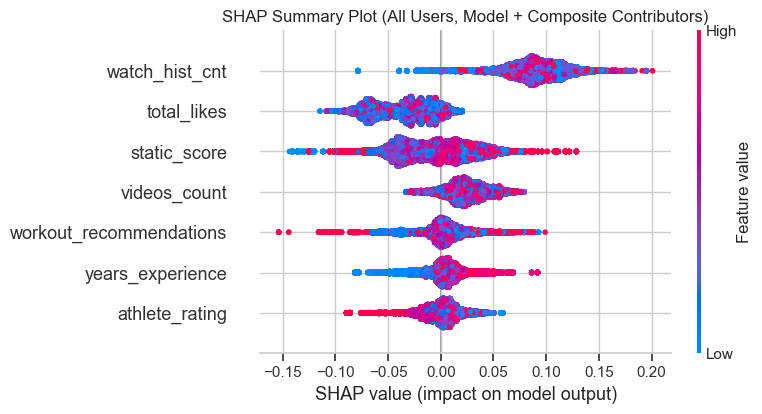

In [51]:
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

np.random.seed(42)

PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
PLOT_PATH  = "/Users/cailingchen/Desktop/Final Project/Plots/shap_summary_all_users.pdf"

pt_df     = pd.read_csv(PT_PATH)
history   = pd.read_csv(HIST_PATH)
ranker    = lgb.Booster(model_file=MODEL_PATH)

merged = pd.merge(history, pt_df, how="left", on="trainer_id")

rename_cols = {
    "athlete_rating_x": "athlete_rating",
    "total_likes_x": "total_likes",
    "videos_count_x": "videos_count",
    "workout_recommendations_x": "workout_recommendations",
    "years_experience_x": "years_experience",
    "specialities": "specialities",  # 保留
}
merged.rename(columns=rename_cols, inplace=True)

for col in ["athlete_rating", "total_likes", "videos_count", "workout_recommendations", "years_experience"]:
    merged[col] = pd.to_numeric(merged[col], errors="coerce").fillna(0)

if "static_score" not in merged.columns:
    scaler_likes  = MinMaxScaler().fit(np.log1p(merged[["total_likes"]]))
    scaler_videos = MinMaxScaler().fit(np.log1p(merged[["videos_count"]]))
    merged["total_likes_norm"]  = scaler_likes.transform(np.log1p(merged[["total_likes"]])).ravel()
    merged["videos_count_norm"] = scaler_videos.transform(np.log1p(merged[["videos_count"]])).ravel()

    for col in ["athlete_rating", "workout_recommendations", "years_experience"]:
        merged[f"{col}_norm"] = MinMaxScaler().fit_transform(merged[[col]]).ravel()

    pca_cols = [
        "total_likes_norm",
        "videos_count_norm",
        "workout_recommendations_norm",
        "athlete_rating_norm",
        "years_experience_norm"
    ]
    pca = PCA(1).fit(merged[pca_cols])
    w = np.abs(pca.components_[0]); w /= w.sum()
    merged["static_score"] = merged[pca_cols].dot(w)


feature_cols = [
    "watch_hist_cnt",
    "athlete_rating", "total_likes", "videos_count",
    "workout_recommendations", "years_experience", "static_score"
]
if "watch_hist_cnt" not in merged.columns:
    merged["watch_hist_cnt"] = merged["watched_count"]

X = merged[feature_cols].copy()
y_pred = ranker.predict(X.values)
merged["pred_score"] = y_pred

explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X)

shap_df = pd.DataFrame(shap_values, columns=feature_cols)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
shap_df = shap_df[mean_abs_shap.index.tolist()]

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, X,
    feature_names=feature_cols, 
    show=False
)
plt.title("SHAP Summary Plot (All Users, Model + Composite Contributors)")
plt.tight_layout()
plt.savefig(PLOT_PATH, format="pdf")
plt.show()


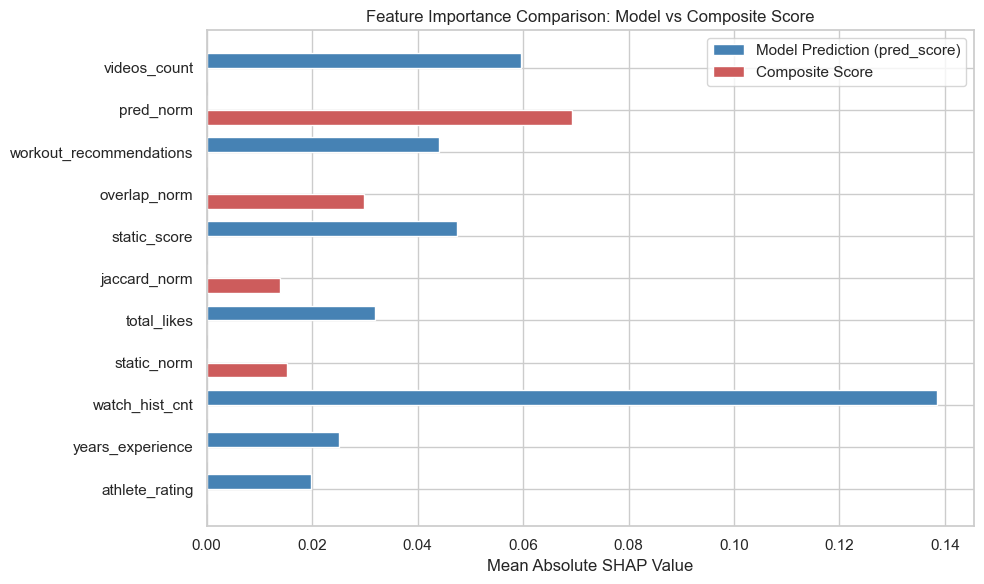

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Compute mean absolute SHAP values
# Model explanation
mean_abs_model = np.abs(shap_vals_model).mean(axis=0)
model_features = feature_cols

# Composite explanation
mean_abs_comp = np.abs(shap_vals_comp).mean(axis=0)
comp_features = ["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]

# Step 2: Create aligned bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize lengths
all_features = list(set(model_features + comp_features))
bar_width = 0.35
x = np.arange(len(all_features))

# Fill missing values with 0 if feature not present
model_vals = [mean_abs_model[model_features.index(f)] if f in model_features else 0 for f in all_features]
comp_vals  = [mean_abs_comp[comp_features.index(f)] if f in comp_features else 0 for f in all_features]

# Plot bars
ax.barh(x - bar_width/2, model_vals, height=bar_width, label='Model Prediction (pred_score)', color='steelblue')
ax.barh(x + bar_width/2, comp_vals,  height=bar_width, label='Composite Score', color='indianred')

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(all_features)
ax.invert_yaxis()  # Highest at top
ax.set_xlabel("Mean Absolute SHAP Value")
ax.set_title("Feature Importance Comparison: Model vs Composite Score")
ax.legend()
plt.tight_layout()

# Optional: Save
# plt.savefig("comparison_plot.pdf", format="pdf")
plt.show()


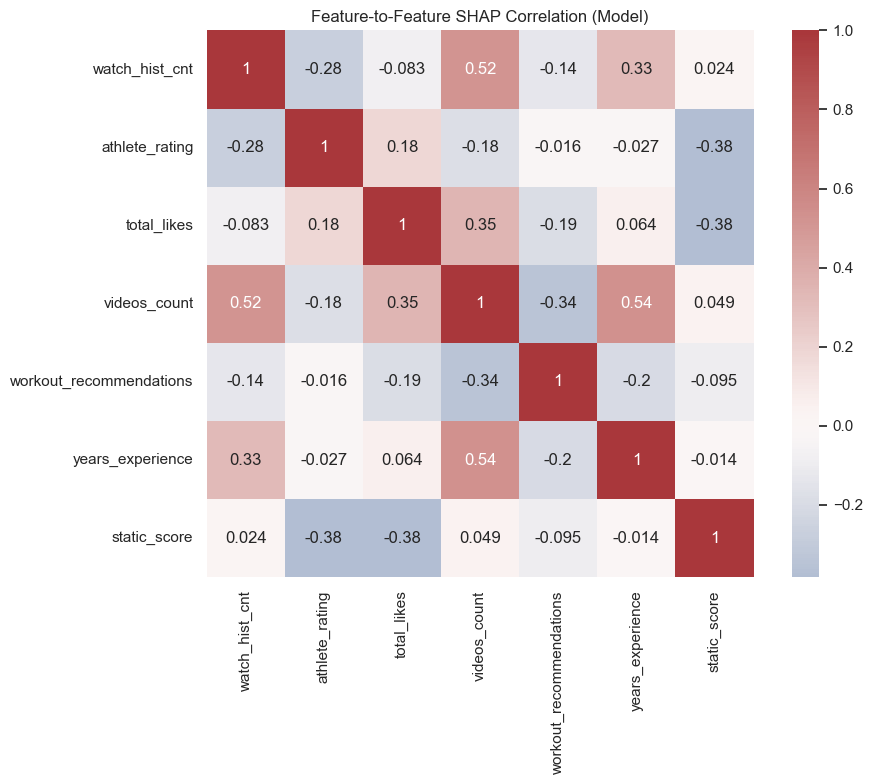

In [53]:
# Compute SHAP value correlation between features (model prediction only)
shap_corr = np.corrcoef(shap_vals_model.T)
shap_corr_df = pd.DataFrame(shap_corr, index=feature_cols, columns=feature_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(shap_corr_df, annot=True, cmap="vlag", center=0, square=True)
plt.title("Feature-to-Feature SHAP Correlation (Model)")
plt.tight_layout()
plt.show()


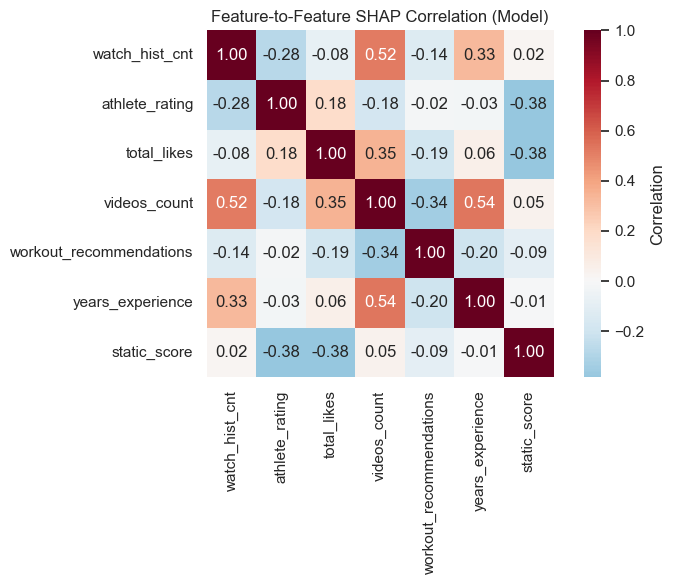

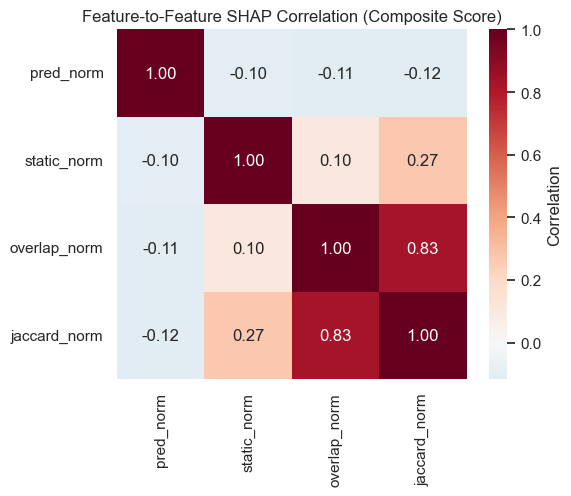

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

model_shap_df = pd.DataFrame(
    shap_vals_model,
    columns=feature_cols
)
model_corr = model_shap_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(model_corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title("Feature-to-Feature SHAP Correlation (Model)")
plt.tight_layout()
plt.show()

composite_cols = ["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]
composite_shap_df = pd.DataFrame(shap_vals_comp, columns=composite_cols)
composite_corr = composite_shap_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(composite_corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title("Feature-to-Feature SHAP Correlation (Composite Score)")
plt.tight_layout()
plt.show()


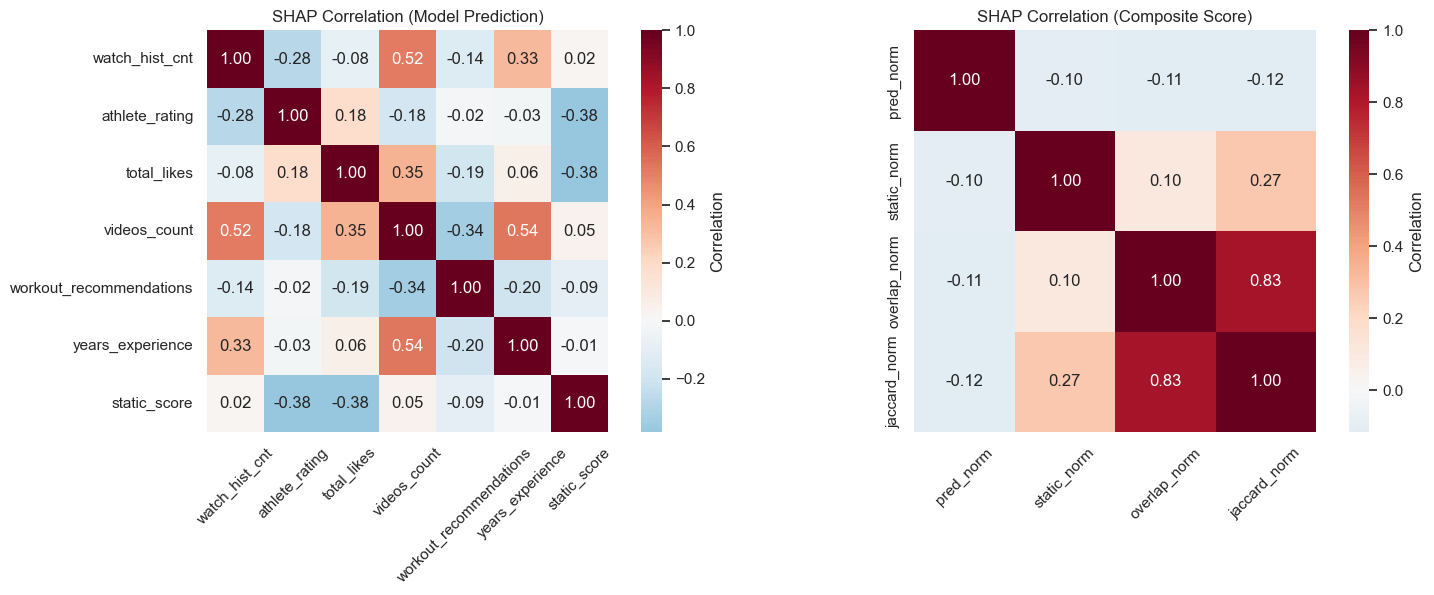

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create DataFrame for SHAP values of model-based features
model_shap_df = pd.DataFrame(shap_vals_model, columns=feature_cols)
model_corr = model_shap_df.corr()

# Create DataFrame for SHAP values of composite score contributors
composite_cols = ["pred_norm", "static_norm", "overlap_norm", "jaccard_norm"]
composite_shap_df = pd.DataFrame(shap_vals_comp, columns=composite_cols)
composite_corr = composite_shap_df.corr()

# Create a side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    model_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation'},
    ax=axes[0]
)
axes[0].set_title("SHAP Correlation (Model Prediction)")
axes[0].tick_params(axis='x', rotation=45)

sns.heatmap(
    composite_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation'},
    ax=axes[1]
)
axes[1].set_title("SHAP Correlation (Composite Score)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Comparison of SHAP Feature Correlation (Model Prediction & Composite Score).pdf", bbox_inches="tight")
plt.show()


### Stepwise recommendations for user 10001 based on composite_score

In [41]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1. Paths & parameters
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
USER_ID    = 10001
TOP_N      = 18

# 2. Load & preprocess trainer static data
trainers = pd.read_csv(PT_PATH)
for col in ["athlete_rating","total_likes","workout_recommendations","years_experience","videos_count"]:
    trainers[col] = pd.to_numeric(trainers[col], errors="coerce").fillna(0)
trainers["specialities"] = trainers["specialities"].astype(str)

# 3. Scale count features (log1p + MinMax)
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[["total_likes"]]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[["videos_count"]]))
trainers["total_likes"]  = scaler_likes.transform(np.log1p(trainers[["total_likes"]]))
trainers["videos_count"] = scaler_videos.transform(np.log1p(trainers[["videos_count"]]))

# 4. Scale other numeric features
for col in ["workout_recommendations","athlete_rating","years_experience"]:
    trainers[col] = MinMaxScaler().fit_transform(trainers[[col]]).ravel()

# 5. Compute static_score via PCA
pca_feats = ["total_likes","videos_count","workout_recommendations","athlete_rating","years_experience"]
pca = PCA(n_components=1).fit(trainers[pca_feats])
weights = np.abs(pca.components_[0]); weights /= weights.sum()
trainers["static_score"] = trainers[pca_feats].dot(weights)

# 6. Load user interaction history
df_hist = pd.read_csv(HIST_PATH)
user_hist = df_hist[df_hist["user_id"] == USER_ID].reset_index(drop=True)
if user_hist.empty:
    raise ValueError(f"No history for user_id={USER_ID}")

goals = user_hist.at[0, "user_goals"]

# 7. Helper functions (tokenize, direction match, related)
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_direction(goals: str, specs: str):
    G = tokenize(goals)
    S = tokenize(specs)
    return int(bool(G & S))

def get_related_trainers(seen_ids, all_trainers, k):
    spec_set = set()
    seen_df = all_trainers[all_trainers["trainer_id"].isin(seen_ids)]
    for specs in seen_df["specialities"].dropna():
        spec_set |= {s.strip().lower() for s in specs.split(",") if s.strip()}
    mask = all_trainers["specialities"].apply(
        lambda s: any(sp in s.lower().split(",") for sp in spec_set)
    )
    return all_trainers[mask & ~all_trainers["trainer_id"].isin(seen_ids)].nlargest(k, "static_score").reset_index(drop=True)

# 8. Stepwise recommendation with 8:2 composite and in-static interest weighting

def stepwise_composite(user_id, history_df, trainers_df, model, feature_cols, top_n,
                        alpha_pred=0.8, alpha_interest=0.2,
                        w_static=0.3, w_overlap=0.4, w_jaccard=0.4):
    # global scaler for static_score
    static_scaler = MinMaxScaler().fit(trainers_df[["static_score"]])

    seq = {}
    events = history_df[history_df["user_id"] == user_id].reset_index(drop=True)

    for step in range(1, len(events) + 1):
        prefix = events.iloc[:step]
        seen   = set(prefix["trainer_id"])

        # 8.1 candidate pool: related trainers only
        pool = get_related_trainers(seen, trainers_df, top_n*5)

        # 8.2 dynamic features: watch count & direction match
        watch_map = prefix.groupby("trainer_id")["watched_count"].sum().to_dict()
        pool["watch_hist_cnt"] = pool["trainer_id"].map(watch_map).fillna(0).astype(int)
        pool["direction_match"] = pool["specialities"].apply(
            lambda s: compute_direction(goals, s)
        )

        # 8.3 predict model score
        pool["pred_score"] = model.predict(pool[feature_cols].values)

        # 8.4 normalize pred and static
        pool["pred_norm"]   = MinMaxScaler().fit_transform(pool[["pred_score"]]).ravel()
        pool["static_norm"] = static_scaler.transform(pool[["static_score"]]).ravel()
        # 8.5 normalize overlap & jaccard
        pool["overlap_norm"] = MinMaxScaler().fit_transform(
            pool[["direction_match"]]  # using direction_match as overlap indicator
        ).ravel()
        pool["jaccard_norm"] = pool["overlap_norm"]  # identical if only direction

        # 8.6 compute in-static interest score
        pool["static_with_interest"] = (
              w_static  * pool["static_norm"]
            + w_overlap * pool["overlap_norm"]
            + w_jaccard * pool["jaccard_norm"]
        )

        # 8.7 composite score
        pool["composite_score"] = (
            alpha_pred     * pool["pred_norm"]
          + alpha_interest * pool["static_with_interest"]
        )

        # 8.8 select top_n
        topn_step = pool.nlargest(top_n, "composite_score").reset_index(drop=True)
        seq[step] = topn_step

        # 8.9 display for this step
        print(f"After interaction {step}:")
        display_cols = ["trainer_id","pred_score","static_score","direction_match","composite_score"]
        print(topn_step[display_cols].to_string(index=False))

    return seq

# 9. Main execution
if __name__ == "__main__":
    # load model
    ranker = lgb.Booster(model_file=MODEL_PATH)
    feature_cols = [
        "watch_hist_cnt","athlete_rating","total_likes","videos_count",
        "workout_recommendations","years_experience","static_score"
    ]
    results = stepwise_composite(
        user_id      = USER_ID,
        history_df   = df_hist,
        trainers_df  = trainers,
        model        = ranker,
        feature_cols = feature_cols,
        top_n        = TOP_N,
        alpha_pred     = 0.8,
        alpha_interest = 0.2,
        w_static       = 0.4,
        w_overlap      = 0.3,
        w_jaccard      = 0.3
    )
    final = results[len(user_hist)]
    print(f"After interaction {len(user_hist)}:")
    print(
        final[["trainer_id","pred_score","static_score",
              "direction_match","composite_score"]]
        .to_string(index=False)
    )


After interaction 1:
 trainer_id  pred_score  static_score  direction_match  composite_score
        422    0.197277      0.693981                0         0.857261
        468    0.138705      0.634421                1         0.846013
        754    0.167522      0.682001                0         0.792285
        196    0.167155      0.637931                0         0.787401
        163    0.164142      0.659169                0         0.782909
        591    0.143643      0.617490                0         0.735037
        426    0.132961      0.677478                0         0.717684
        393    0.132552      0.680683                0         0.717106
        215    0.127298      0.705991                0         0.708180
        637    0.125240      0.704822                0         0.703655
        232    0.127393      0.645999                0         0.702810
        504    0.066106      0.531909                1         0.680666
        890    0.116531      0.650000      

### Show recommendation changes by Rank Matrix 

In [61]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 1. Paths & parameters
PT_PATH    = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
USER_ID    = 10001
TOP_N      = 18

# 2. Load & preprocess trainer static data
def load_trainers(path):
    df = pd.read_csv(path)
    for col in ["athlete_rating","total_likes","workout_recommendations","years_experience","videos_count"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)
    df["specialities"] = df["specialities"].astype(str)
    # scale counts
    scaler_likes = MinMaxScaler().fit(np.log1p(df[["total_likes"]]))
    scaler_videos = MinMaxScaler().fit(np.log1p(df[["videos_count"]]))
    df["total_likes"] = scaler_likes.transform(np.log1p(df[["total_likes"]])).ravel()
    df["videos_count"] = scaler_videos.transform(np.log1p(df[["videos_count"]])).ravel()
    # scale others
    for c in ["workout_recommendations","athlete_rating","years_experience"]:
        df[c] = MinMaxScaler().fit_transform(df[[c]]).ravel()
    # static PCA
    pca_feats = ["total_likes","videos_count","workout_recommendations","athlete_rating","years_experience"]
    pca = PCA(n_components=1).fit(df[pca_feats])
    w = np.abs(pca.components_[0]); w /= w.sum()
    df["static_score"] = df[pca_feats].dot(w)
    return df, scaler_likes, scaler_videos

# 3. Tokenize & related helpers
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_direction(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    return int(bool(G & S))

def get_related_trainers(seen_ids, trainers_df, k):
    spec_set = set()
    seen_df = trainers_df[trainers_df["trainer_id"].isin(seen_ids)]
    for specs in seen_df["specialities"].dropna():
        spec_set |= tokenize(specs)
    mask = trainers_df["specialities"].apply(lambda s: bool(spec_set & tokenize(s)))
    return trainers_df[mask & ~trainers_df["trainer_id"].isin(seen_ids)] \
                      .nlargest(k, "static_score").reset_index(drop=True)

# 4. Stepwise recommendation without intermediate prints

def stepwise_composite(user_id, history_df, trainers_df, model, feature_cols, top_n,
                        alpha_pred=0.8, alpha_interest=0.2,
                        w_static=0.3, w_overlap=0.4, w_jaccard=0.4):
    # global static scaler
    static_scaler = MinMaxScaler().fit(trainers_df[["static_score"]])
    seq = {}
    events = history_df[history_df["user_id"] == user_id].reset_index(drop=True)
    goals = events.at[0, "user_goals"]
    for step in range(1, len(events)+1):
        prefix = events.iloc[:step]
        seen = set(prefix["trainer_id"])
        # 4.1 build pool
        pool = get_related_trainers(seen, trainers_df, top_n*5)
        # 4.2 dynamic features
        watch_map = prefix.groupby("trainer_id")["watched_count"].sum().to_dict()
        pool["watch_hist_cnt"] = pool["trainer_id"].map(watch_map).fillna(0).astype(int)
        pool["direction_match"] = pool["specialities"].apply(lambda s: compute_direction(goals, s))
        # 4.3 model prediction
        pool["pred_score"] = model.predict(pool[feature_cols].values)
        # 4.4 normalization
        pool["pred_norm"] = MinMaxScaler().fit_transform(pool[["pred_score"]]).ravel()
        pool["static_norm"] = static_scaler.transform(pool[["static_score"]]).ravel()
        pool["overlap_norm"] = MinMaxScaler().fit_transform(pool[["direction_match"]]).ravel()
        pool["jaccard_norm"] = pool["overlap_norm"]
        # 4.5 in-static interest
        pool["static_with_interest"] = (
              w_static * pool["static_norm"]
            + w_overlap * pool["overlap_norm"]
            + w_jaccard * pool["jaccard_norm"]
        )
        # 4.6 composite
        pool["composite_score"] = (
            alpha_pred * pool["pred_norm"] + alpha_interest * pool["static_with_interest"]
        )
        # 4.7 select top_n
        seq[step] = pool.nlargest(top_n, "composite_score").reset_index(drop=True)
    return seq

# 5. Build rank matrix using composite ranks
def build_rank_matrix(seq):
    all_ids = sorted({tid for df in seq.values() for tid in df["trainer_id"]})
    steps = sorted(seq.keys())
    cols = [f"step_{s}" for s in steps]
    mat = pd.DataFrame(index=all_ids, columns=cols, dtype=float)
    for s in steps:
        order = list(seq[s]["trainer_id"])
        for tid in all_ids:
            mat.at[tid, f"step_{s}"] = order.index(tid)+1 if tid in order else np.nan
    return mat

# 6. Main execution
if __name__ == "__main__":
    trainers, scaler_likes, scaler_videos = load_trainers(PT_PATH)
    history_df = pd.read_csv(HIST_PATH)
    model = lgb.Booster(model_file=MODEL_PATH)
    feature_cols = [
        "watch_hist_cnt","athlete_rating","total_likes","videos_count",
        "workout_recommendations","years_experience","static_score"
    ]
    seq = stepwise_composite(
        user_id=USER_ID,
        history_df=history_df,
        trainers_df=trainers,
        model=model,
        feature_cols=feature_cols,
        top_n=TOP_N,
        alpha_pred=0.8,
        alpha_interest=0.2,
        w_static=0.3,
        w_overlap=0.4,
        w_jaccard=0.4
    )
    # build and print rank matrix
    rank_matrix = build_rank_matrix(seq)
    print("Composite rank matrix across steps:")
    print(rank_matrix)


Composite rank matrix across steps:
     step_1  step_2  step_3  step_4  step_5  step_6  step_7  step_8  step_9  \
36      NaN     NaN    12.0     NaN     NaN     NaN     NaN     NaN     NaN   
63      NaN     5.0     6.0     NaN     NaN     NaN     NaN     NaN     NaN   
74     10.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
80      NaN     7.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
83      NaN     NaN     NaN    18.0    16.0    17.0    13.0    12.0    12.0   
89      NaN     9.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
93      NaN     NaN    11.0     7.0     NaN     NaN     NaN     NaN     NaN   
128     NaN     NaN     7.0     5.0     5.0     5.0     4.0     4.0     4.0   
134     NaN     NaN     4.0     3.0     3.0     3.0     2.0     2.0     2.0   
156    14.0    11.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
163     8.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
166     NaN    1

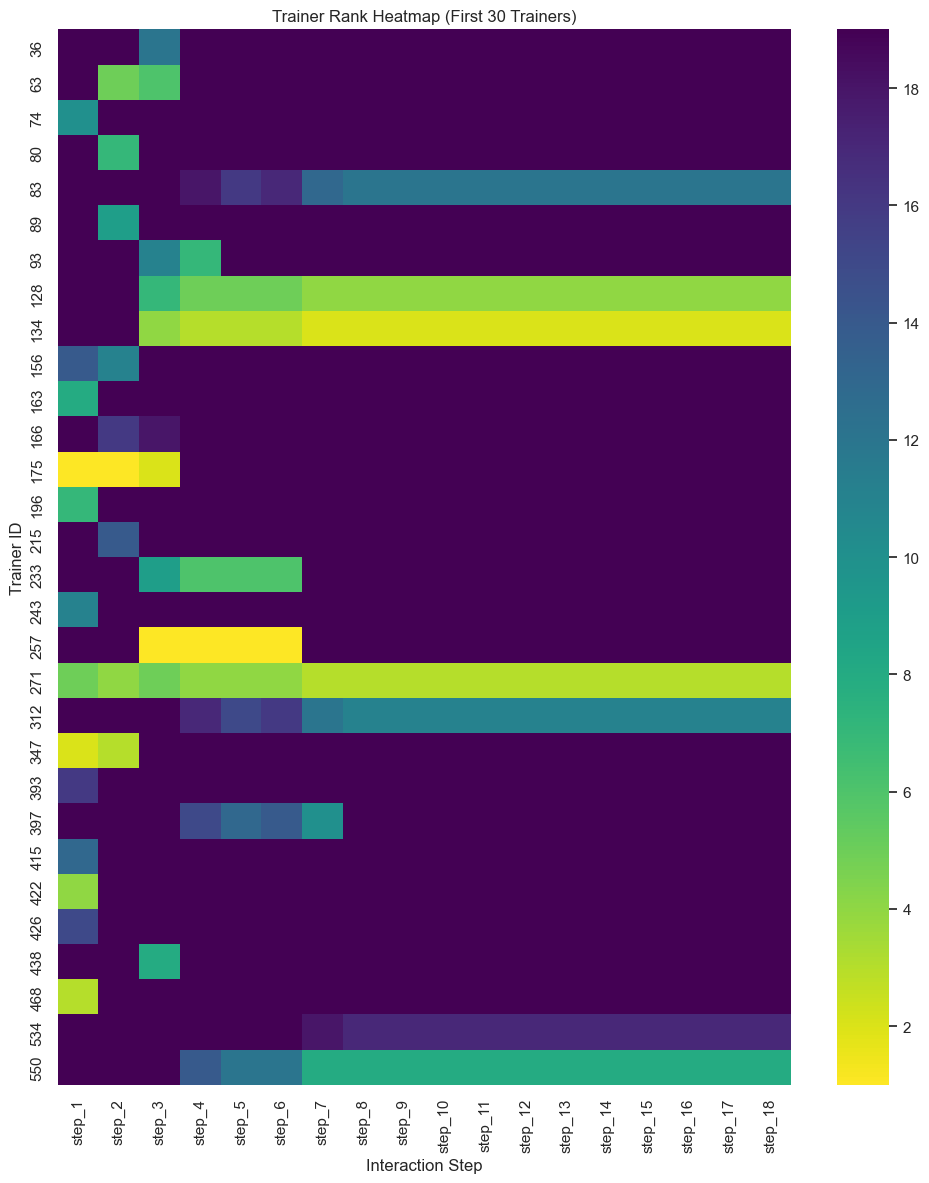

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 7. Visualize rank matrix as heatmap
def plot_rank_heatmap(rank_matrix, max_rows=30):
    limited = rank_matrix.head(max_rows).fillna(rank_matrix.shape[1] + 1)

    plt.figure(figsize=(10, max_rows * 0.4))
    sns.heatmap(limited, cmap="viridis_r", annot=False, cbar=True)
    plt.title("Trainer Rank Heatmap (First {} Trainers)".format(max_rows))
    plt.xlabel("Interaction Step")
    plt.ylabel("Trainer ID")
    plt.tight_layout()
    plt.show()

# Call the heatmap plot
plot_rank_heatmap(rank_matrix)


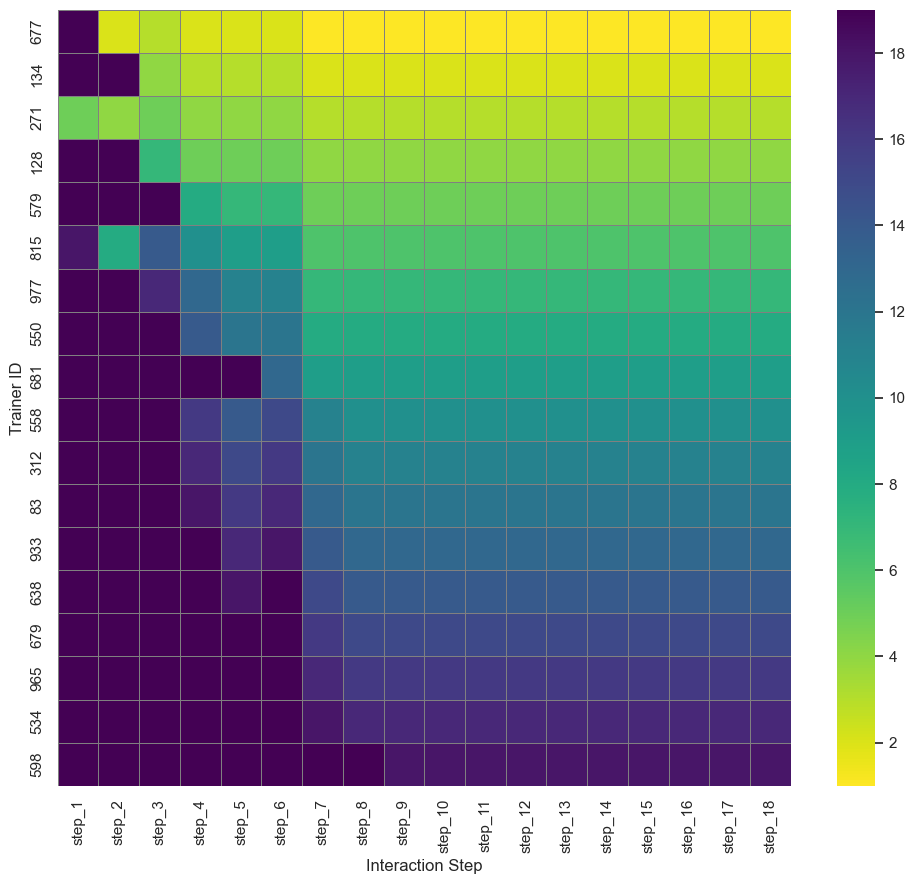

In [65]:
def plot_topN_rank_heatmap(rank_matrix, top_n=18):

    last_step = rank_matrix.columns[-1]
    top_ids = rank_matrix[last_step].nsmallest(top_n).index


    sub_rank = rank_matrix.loc[top_ids].fillna(top_n + 1)

    plt.figure(figsize=(10, top_n * 0.5))
    sns.heatmap(sub_rank, cmap="viridis_r", annot=False, fmt=".0f", cbar=True,
                linewidths=0.5, linecolor='gray')
    # plt.title(f"Top-{top_n} Trainer Ranking Heatmap Over Steps", fontsize=14)
    plt.xlabel("Interaction Step")
    plt.ylabel("Trainer ID")
    plt.tight_layout()
    plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Example User 10001 - Top 18 Trainer Ranking Heatmap Over Steps.pdf")
    plt.show()
    
plot_topN_rank_heatmap(rank_matrix)


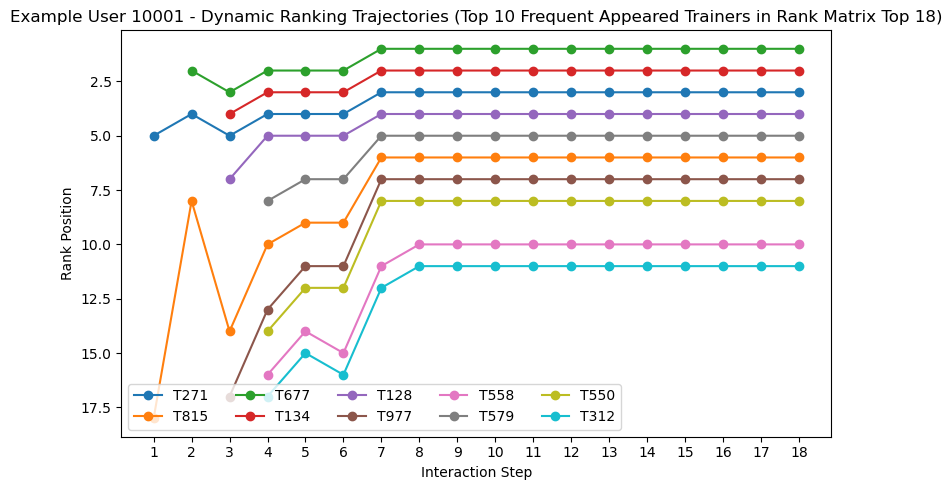

In [52]:
# Visualization of top 10 ranking changes of user 10001
import matplotlib.pyplot as plt

# Select top 10 trainers by frequency of appearance in Top-N across steps
freq = rank_matrix.notna().sum(axis=1)
top10 = freq.sort_values(ascending=False).head(10).index

plt.figure(figsize=(8,5))
for tid in top10:
    ys = rank_matrix.loc[tid, [f"step_{i}" for i in sorted(seq.keys())]]
    plt.plot(sorted(seq.keys()), ys, marker='o', label=f"T{tid}")

plt.gca().invert_yaxis()
plt.xticks(sorted(seq.keys()))
plt.xlabel("Interaction Step")
plt.ylabel("Rank Position")
plt.title(f"Example User {USER_ID} - Dynamic Ranking Trajectories (Top 10 Frequent Appeared Trainers in Rank Matrix Top {TOP_N})")
plt.legend(ncol=5, loc='lower left')
plt.tight_layout()
# plt.savefig(f"/Users/cailingchen/Desktop/Final Project/Plots/Dynamic Ranking Trajectories_ExampleUser{USER_ID}.png")
plt.show()


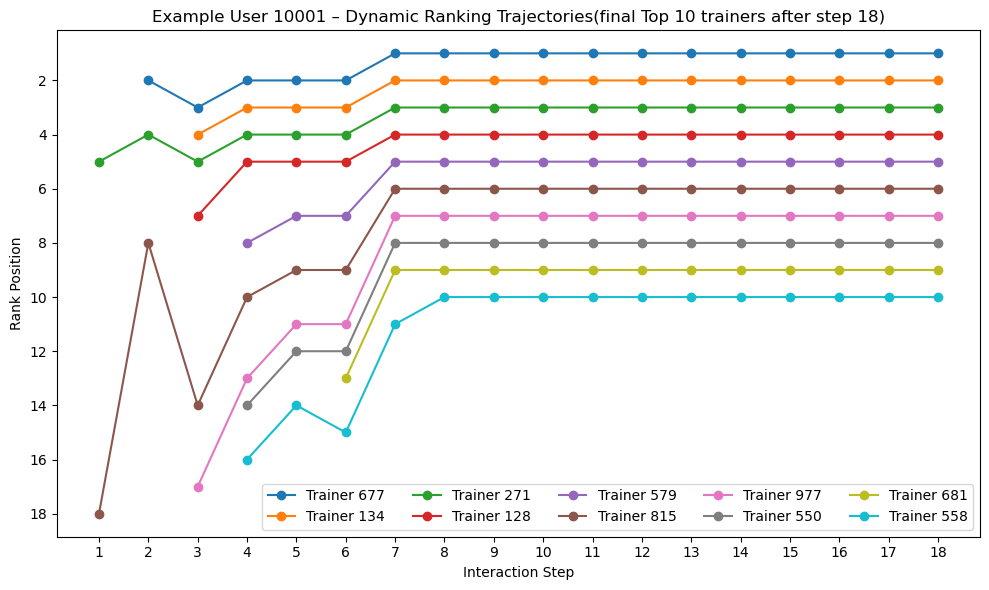

Final Top10 after step 18:
 trainer_id  pred_score
        677    0.264926
        134    0.114023
        271    0.096572
        128    0.093044
        579    0.149907
        815    0.051131
        977    0.025662
        550    0.021815
        681    0.107138
        558    0.093650


In [62]:
# Visualization of final Top 10 trainer trajectories after all interactions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the Top 10 after all interactions are completed
last_step = max(seq.keys())
final_df  = seq[last_step].reset_index(drop=True)
top10_ids = final_df['trainer_id'].head(10).astype(str).tolist()

# Construct a rank_matrix: rows are the 10 trainers, columns are each step, values are rank positions
steps       = sorted(seq.keys())
traj_matrix = pd.DataFrame(index=top10_ids, columns=steps, dtype=float)
for step in steps:
    ids = seq[step]['trainer_id'].astype(str).tolist()
    for tid in top10_ids:
        traj_matrix.at[tid, step] = ids.index(tid) + 1 if tid in ids else np.nan

# Plot the ranking trajectory of these final Top 10 trainers
plt.figure(figsize=(10, 6))
for tid in top10_ids:
    plt.plot(
        steps,
        traj_matrix.loc[tid],
        marker='o',
        label=f'Trainer {tid}'
    )

ax = plt.gca()
ax.invert_yaxis()  # rank 1 at top
# force y-axis to integer ticks
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(steps)

plt.xlabel("Interaction Step")
plt.ylabel("Rank Position")
plt.title(f"Example User {USER_ID} – Dynamic Ranking Trajectories(final Top 10 trainers after step {last_step})")
plt.legend(loc="lower right", ncol=5)
plt.tight_layout()
# plt.savefig(f"/Users/cailingchen/Desktop/Final Project/Plots/Dynamic_Ranking_Trajectories_FinalTop10_User{USER_ID}.png")
plt.show()

# Print final Top 10 and their predicted scores
print(f"Final Top10 after step {last_step}:")
print(final_df[['trainer_id', 'pred_score']].head(10).to_string(index=False))


## Second round user interaction generation & Evaluation through user interaction level before and after trainer recommendation

In [69]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import matplotlib.pyplot as plt

# Paths and parameters
PT_PATH     = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
OUTPUT_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000.csv"
TOP_K       = 18
VIDEO_NUM   = 5
ALPHA       = 0.05
P_MAX       = 0.95

# Helper functions
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), len(I)/len(U) if U else 0.0, int(bool(I))

def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated == 1:
        return score_given if score_given >= 3 else 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1

# Load trainer data and compute static_score via PCA
trainers = pd.read_csv(PT_PATH)
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)
trainers['specialities'] = trainers['specialities'].astype(str)

# Normalize for PCA
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()
# PCA static_score
dims = ['total_likes_norm','videos_count_norm','workout_recommendations_norm','athlete_rating_norm','years_experience_norm']
pca = PCA(n_components=1).fit(trainers[dims])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[dims].dot(w)

# Load history and model
history_df = pd.read_csv(HIST_PATH)
ranker     = lgb.Booster(model_file=MODEL_PATH)

# Stepwise recommendation function
from sklearn.preprocessing import MinMaxScaler as _MMS  # avoid clash

def stepwise_recommendations(user_id, history_df, trainers_df, model, feature_cols, top_n):
    # global static scaler
    static_scaler = _MMS().fit(trainers_df[['static_score']])
    events = history_df[history_df['user_id']==user_id].reset_index(drop=True)
    goals = events.at[0,'user_goals']
    seq = {}
    for step in range(1, len(events)+1):
        prefix = events.iloc[:step]
        seen   = set(prefix['trainer_id'])
        # pool of related trainers
        pool = trainers_df.copy()
        ov = pool['specialities'].apply(lambda s: compute_overlap(goals, s))
        pool['overlap_count'], pool['jaccard_score'], pool['direction_match'] = zip(*ov)
        watch_map = prefix.groupby('trainer_id')['watched_count'].sum().to_dict()
        pool['watch_hist_cnt'] = pool['trainer_id'].map(watch_map).fillna(0).astype(int)
        # scale counts
        pool['total_likes']  = scaler_likes.transform(np.log1p(pool[['total_likes']])).ravel()
        pool['videos_count'] = scaler_videos.transform(np.log1p(pool[['videos_count']])).ravel()
        # predict
        pool['pred_score'] = model.predict(pool[feature_cols].values)
        pool['pred_norm']  = _MMS().fit_transform(pool[['pred_score']]).ravel()
        pool['static_norm']= static_scaler.transform(pool[['static_score']]).ravel()
        # composite as 70% model, 30% static
        pool['composite_score'] = 0.7*pool['pred_norm'] + 0.3*pool['static_norm']
        seq[step] = pool.nlargest(top_n, 'composite_score')[['trainer_id','composite_score']].reset_index(drop=True)
    return seq

# Generate stepwise sequences and extract final Top-K per user
feature_cols = ['watch_hist_cnt','athlete_rating','total_likes','videos_count','workout_recommendations','years_experience','static_score']
seq_map = {}
first_round = []
for user_id in history_df['user_id'].unique():
    seq = stepwise_recommendations(user_id, history_df, trainers, ranker, feature_cols, TOP_K)
    last = seq[len(history_df[history_df['user_id']==user_id])]
    for _, row in last.iterrows():
        first_round.append({'user_id':user_id,'trainer_id':row['trainer_id']})
first_round = pd.DataFrame(first_round)

# Second-round: simulate interactions on that final Top-K
second_records = []
for user_id, recs in first_round.groupby('user_id', sort=False):
    ev = history_df[history_df['user_id']==user_id].reset_index(drop=True)
    goals = ev.at[0,'user_goals']
    prior = ev.groupby('trainer_id')['watched_count'].sum().to_dict()
    for _, r in recs.iterrows():
        tid = r['trainer_id']
        # compute overlap
        spec = trainers.loc[trainers['trainer_id']==tid,'specialities'].iloc[0]
        ov_count, ov_jac, ov_dir = compute_overlap(goals, spec)
        base_prob = min(0.2 + 0.2*ov_count, P_MAX)
        watch_sum, flags = 0, []
        for _ in range(VIDEO_NUM):
            p = min(base_prob + ALPHA*watch_sum, P_MAX)
            w = int(random.random()<p)
            flags.append(w); watch_sum+=w
        if watch_sum>=2:
            rated_prob = min(0.1+0.15*watch_sum+0.4*ov_jac, P_MAX)
            rated = int(random.random()<rated_prob)
        else:
            rated = 0
        if rated:
            raw = np.random.normal(loc=2.5Cold+0.3*watch_sum+1.5*ov_jac, scale=1.2)
            score_given = int(np.clip(round(raw),1,5))
        else:
            score_given = 0
        label = construct_label(watch_sum, rated, score_given)
        record = {'user_id':user_id,'trainer_id':tid,'watched_count':watch_sum,'rated':rated,'score_given':score_given,'overlap_count':ov_count,'jaccard_score':ov_jac,'direction_match':ov_dir,'label':label}
        for i, w in enumerate(flags,1): record[f'watch_v{i}']=w
        second_records.append(record)
second_round = pd.DataFrame(second_records)
second_round.to_csv(OUTPUT_PATH,index=False)




Label Distribution Comparison:
       After cold start recommendation  After second round recommendation
label                                                                    
0                                27382                              25667
1                                31457                              30068
2                                18361                              18823
3                                 5099                               5894
4                                 4259                               5043
5                                 3442                               4505


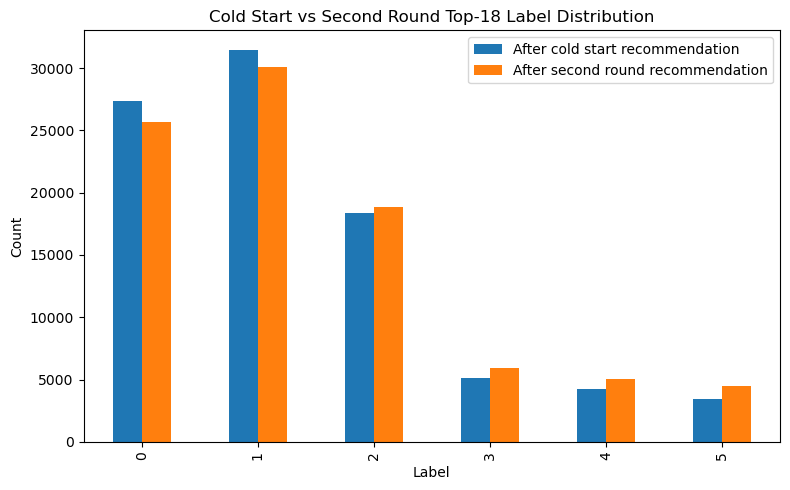

In [12]:
# Compare label distributions
import pandas as pd
import matplotlib.pyplot as plt

HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
history_df = pd.read_csv(HIST_PATH)

SECOND_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000.csv"
second_round = pd.read_csv(SECOND_PATH)

orig = history_df['label'].value_counts().sort_index()
new  = second_round['label'].value_counts().sort_index()
df_cmp = pd.DataFrame({'After cold start recommendation':orig,'After second round recommendation':new}).fillna(0).astype(int)
print("Label Distribution Comparison:")
print(df_cmp)
df_cmp.plot(kind='bar',figsize=(8,5))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Cold Start vs Second Round Top-18 Label Distribution')
plt.tight_layout()
plt.show()

In [101]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import matplotlib.pyplot as plt

# Paths and parameters
PT_PATH     = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
OUTPUT_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_v2.csv"
TOP_K       = 18
VIDEO_NUM   = 5
ALPHA       = 0.05
P_MAX       = 0.95

# Helper functions
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), len(I)/len(U) if U else 0.0, int(bool(I))

def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated == 1:
        return score_given if score_given >= 3 else 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1

# 1. Load & preprocess trainer data
trainers = pd.read_csv(PT_PATH)
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)
trainers['specialities'] = trainers['specialities'].astype(str)

# 2. Compute static_score via PCA
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()
dims = [
    'total_likes_norm','videos_count_norm',
    'workout_recommendations_norm','athlete_rating_norm','years_experience_norm'
]
pca = PCA(n_components=1).fit(trainers[dims])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[dims].dot(w)

# 3. Load history & model
history_df = pd.read_csv(HIST_PATH)
ranker     = lgb.Booster(model_file=MODEL_PATH)

# 4. One‑shot Top‑K recommendation per user
first_round = []
feature_cols = [
    'watch_hist_cnt',
    'athlete_rating','total_likes','videos_count',
    'workout_recommendations','years_experience','static_score'
]

for user_id, ev in history_df.groupby('user_id', sort=False):
    ev = ev.reset_index(drop=True)
    goals = ev.at[0,'user_goals']

    # compute dynamic features on full pool
    pool = trainers.copy()
    watch_map = ev.groupby('trainer_id')['watched_count'].sum().to_dict()
    pool['watch_hist_cnt'] = pool['trainer_id'].map(watch_map).fillna(0).astype(int)
    ov = pool['specialities'].apply(lambda s: compute_overlap(goals, s))
    pool['overlap_count'], pool['jaccard_score'], pool['direction_match'] = zip(*ov)

    # re-scale count features
    pool['total_likes']  = scaler_likes.transform(np.log1p(pool[['total_likes']])).ravel()
    pool['videos_count'] = scaler_videos.transform(np.log1p(pool[['videos_count']])).ravel()

    # model prediction + normalize
    pool['pred_score'] = ranker.predict(pool[feature_cols].values)
    pool['pred_norm']  = MinMaxScaler().fit_transform(pool[['pred_score']]).ravel()
    pool['dir_norm']   = MinMaxScaler().fit_transform(pool[['direction_match']]).ravel()

    # composite = 80% model + 20% direction_match
    pool['composite_score'] = 0.8 * pool['pred_norm'] + 0.2 * pool['dir_norm']

    # select Top_K
    topk = pool.nlargest(TOP_K, 'composite_score')[['trainer_id']].copy()
    topk['user_id'] = user_id
    first_round.append(topk)

first_round = pd.concat(first_round, ignore_index=True)

# 5. Simulate second‑round interactions
second_records = []
for user_id, recs in first_round.groupby('user_id', sort=False):
    ev = history_df[history_df['user_id']==user_id].reset_index(drop=True)
    goals = ev.at[0,'user_goals']
    for _, r in recs.iterrows():
        tid = r['trainer_id']
        ov_count, ov_jac, ov_dir = compute_overlap(goals,
            trainers.loc[trainers['trainer_id']==tid,'specialities'].iloc[0])
        base_prob = min(0.2 + 0.2*ov_count, P_MAX)
        watch_sum, flags = 0, []
        for _ in range(VIDEO_NUM):
            p = min(base_prob + ALPHA*watch_sum, P_MAX)
            w = int(random.random()<p)
            flags.append(w); watch_sum+=w
        if watch_sum>=2:
            rp = min(0.1+0.15*watch_sum+0.4*ov_jac, P_MAX)
            rated = int(random.random()<rp)
        else:
            rated = 0
        if rated:
            raw = np.random.normal(loc=2.5+0.3*watch_sum+1.5*ov_jac,scale=1.2)
            score_given = int(np.clip(round(raw),1,5))
        else:
            score_given = 0
        label = construct_label(watch_sum, rated, score_given)
        rec = {
            'user_id':user_id,'trainer_id':tid,
            'watched_count':watch_sum,'rated':rated,'score_given':score_given,
            'overlap_count':ov_count,'jaccard_score':ov_jac,'direction_match':ov_dir,
            'label':label
        }
        for i,w in enumerate(flags,1):
            rec[f'watch_v{i}'] = w
        second_records.append(rec)

second_round = pd.DataFrame(second_records)
second_round.to_csv(OUTPUT_PATH, index=False)


Label Distribution Comparison:
       After cold start recommendation  After second round recommendation
label                                                                    
0                                27382                              16627
1                                31457                              25136
2                                18361                              20579
3                                 5099                               8477
4                                 4259                               9185
5                                 3442                               9996


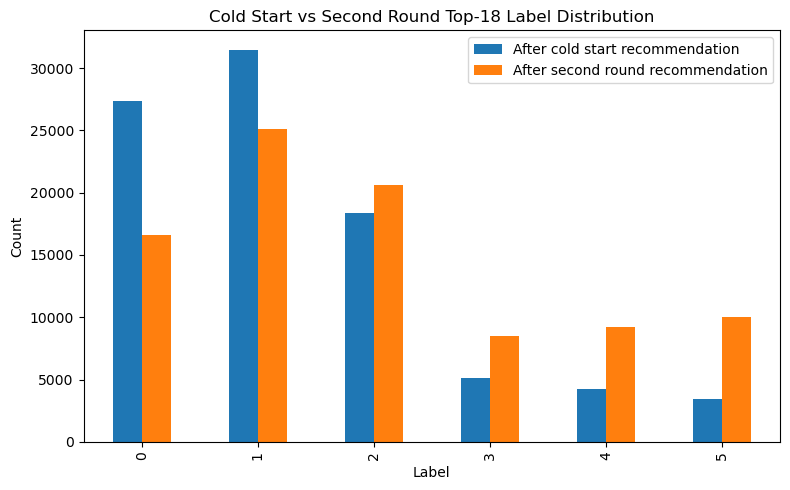

In [11]:
# Label distribution comparison
import pandas as pd
import matplotlib.pyplot as plt

HIST_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
history_df = pd.read_csv(HIST_PATH)

SECOND_PATH   = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_v2.csv"
second_round = pd.read_csv(SECOND_PATH)

orig = history_df['label'].value_counts().sort_index()
new  = second_round['label'].value_counts().sort_index()
df_cmp = pd.DataFrame({'After cold start recommendation':orig,'After second round recommendation':new}).fillna(0).astype(int)
print("Label Distribution Comparison:")
print(df_cmp)
df_cmp.plot(kind='bar', figsize=(8,5))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Cold Start vs Second Round Top-18 Label Distribution')
plt.tight_layout()
plt.show()


### Third round recommendation

In [18]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import matplotlib.pyplot as plt

# Paths and parameters
PT_PATH     = "/Users/cailingchen/Desktop/Final Project/PT_Dataset.csv"
SECOND_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_v2.csv"
MODEL_PATH  = "/Users/cailingchen/Desktop/Final Project/Model/lambdarank_model_user_updated.txt"
OUTPUT_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/third_round_interactions_5000_v3.csv"
TOP_K       = 18
VIDEO_NUM   = 5
ALPHA       = 0.05
P_MAX       = 0.95

# Helper functions
def tokenize(text: str):
    return {tok.strip().lower() for tok in re.split(r"[,;/、]", text) if tok.strip()}

def compute_overlap(goals: str, specs: str):
    G, S = tokenize(goals), tokenize(specs)
    I, U = G & S, G | S
    return len(I), len(I)/len(U) if U else 0.0, int(bool(I))

def construct_label(watched_count, rated, score_given):
    if watched_count == 0:
        return 0
    if rated == 1:
        return score_given if score_given >= 3 else 2
    if watched_count > 3:
        return 3
    if watched_count > 1:
        return 2
    return 1

# 1. Load & preprocess trainer data
trainers = pd.read_csv(PT_PATH)
for col in ['athlete_rating','total_likes','workout_recommendations','years_experience','videos_count']:
    trainers[col] = pd.to_numeric(trainers[col], errors='coerce').fillna(0)
trainers['specialities'] = trainers['specialities'].astype(str)

# 2. Compute static_score via PCA
scaler_likes  = MinMaxScaler().fit(np.log1p(trainers[['total_likes']]))
scaler_videos = MinMaxScaler().fit(np.log1p(trainers[['videos_count']]))
trainers['total_likes_norm']  = scaler_likes.transform(np.log1p(trainers[['total_likes']])).ravel()
trainers['videos_count_norm'] = scaler_videos.transform(np.log1p(trainers[['videos_count']])).ravel()
for c in ['workout_recommendations','athlete_rating','years_experience']:
    trainers[f'{c}_norm'] = MinMaxScaler().fit_transform(trainers[[c]]).ravel()
dims = ['total_likes_norm','videos_count_norm','workout_recommendations_norm','athlete_rating_norm','years_experience_norm']
pca = PCA(n_components=1).fit(trainers[dims])
w = np.abs(pca.components_[0]); w /= w.sum()
trainers['static_score'] = trainers[dims].dot(w)

# 3. Load second-round history & model
history_2 = pd.read_csv(SECOND_PATH)
orig     = pd.read_csv(HIST_PATH)[['user_id','user_goals']].drop_duplicates()
history_2 = history_2.merge(orig, on='user_id', how='left')

ranker    = lgb.Booster(model_file=MODEL_PATH)

# 4. Define one-shot top-K (reuses PCA/static etc.)
feature_cols = [
    'watch_hist_cnt','athlete_rating','total_likes','videos_count',
    'workout_recommendations','years_experience','static_score'
]
def one_shot_topk(history_df):
    recs = []
    for uid, ev in history_df.groupby('user_id', sort=False):
        ev = ev.reset_index(drop=True)
        goals = ev.at[0,'user_goals']
        pool = trainers.copy()
        # dynamic features
        watch_map = ev.groupby('trainer_id')['watched_count'].sum().to_dict()
        pool['watch_hist_cnt'] = pool['trainer_id'].map(watch_map).fillna(0).astype(int)
        ov = pool['specialities'].apply(lambda s: compute_overlap(goals, s))
        pool['overlap_count'], pool['jaccard_score'], pool['direction_match'] = zip(*ov)
        # re-scale counts
        pool['total_likes']  = scaler_likes.transform(np.log1p(pool[['total_likes']])).ravel()
        pool['videos_count'] = scaler_videos.transform(np.log1p(pool[['videos_count']])).ravel()
        # predict + normalize
        pool['pred_score'] = ranker.predict(pool[feature_cols].values)
        pool['pred_norm']  = MinMaxScaler().fit_transform(pool[['pred_score']]).ravel()
        pool['dir_norm']   = MinMaxScaler().fit_transform(pool[['direction_match']]).ravel()
        # composite 80/20
        pool['composite_score'] = 0.8*pool['pred_norm'] + 0.2*pool['dir_norm']
        topk = pool.nlargest(TOP_K, 'composite_score')[['trainer_id']].copy()
        topk['user_id'] = uid
        recs.append(topk)
    return pd.concat(recs, ignore_index=True)

# 5. Define simulate_round
def simulate_round(first_round, history_df):
    recs = []
    for uid, fr in first_round.groupby('user_id', sort=False):
        ev = history_df[history_df['user_id']==uid].reset_index(drop=True)
        goals = ev.at[0,'user_goals']
        for _, r in fr.iterrows():
            tid = r['trainer_id']
            ov_c, ov_j, ov_d = compute_overlap(goals,
                trainers.loc[trainers['trainer_id']==tid,'specialities'].iloc[0])
            base = min(0.2+0.2*ov_c, P_MAX)
            watch_sum, flags = 0, []
            for _ in range(VIDEO_NUM):
                p = min(base + ALPHA*watch_sum, P_MAX)
                w = int(random.random()<p)
                flags.append(w); watch_sum+=w
            if watch_sum>=2:
                rp = min(0.1+0.15*watch_sum+0.4*ov_j, P_MAX)
                rated = int(random.random()<rp)
            else:
                rated = 0
            score = int(np.clip(round(np.random.normal(
                2.5+0.3*watch_sum+1.5*ov_j,
                1.2)),1,5)) if rated else 0
            label = construct_label(watch_sum, rated, score)
            rec = {
                'user_id':uid,'trainer_id':tid,'watched_count':watch_sum,
                'rated':rated,'score_given':score,
                'overlap_count':ov_c,'jaccard_score':ov_j,'direction_match':ov_d,
                'label':label
            }
            for i,w in enumerate(flags,1): rec[f'watch_v{i}']=w
            recs.append(rec)
    return pd.DataFrame(recs)

# 6. Run one-shot on Round2 → produce Round3
first_2 = one_shot_topk(history_2)
round_3 = simulate_round(first_2, history_2)
round_3.to_csv(OUTPUT_PATH, index=False)


Label distribution comparison across rounds:
       Round 1: Cold start recommendations  \
label                                        
0                                    27382   
1                                    31457   
2                                    18361   
3                                     5099   
4                                     4259   
5                                     3442   

       Round 2: First round LambdaRank recommendations  \
label                                                    
0                                                16627   
1                                                25136   
2                                                20579   
3                                                 8477   
4                                                 9185   
5                                                 9996   

       Round 3: Second round LambdaRank recommendations  
label                                                    
0    

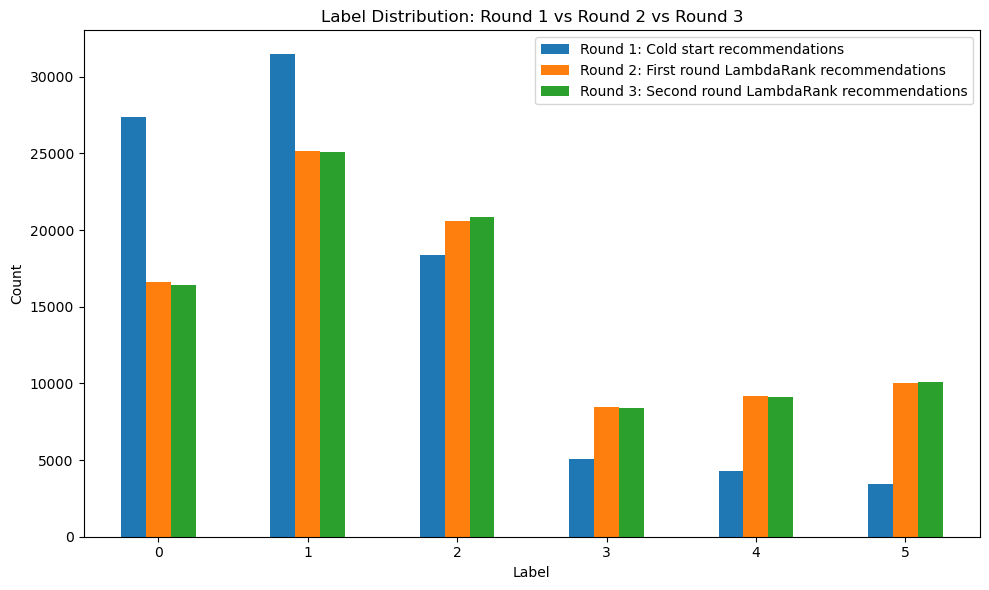

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for each round’s interaction data
FIRST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
SECOND_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_v2.csv"
THIRD_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/third_round_interactions_5000_v3.csv"

# Load the data for each round
df1 = pd.read_csv(FIRST_PATH)    # Round 1 (original synthetic data)
df2 = pd.read_csv(SECOND_PATH)   # Round 2 (simulated interactions)
df3 = pd.read_csv(THIRD_PATH)    # Round 3 (simulated interactions)

# Compute the label distribution for each round
dist1 = df1['label'].value_counts().sort_index()
dist2 = df2['label'].value_counts().sort_index()
dist3 = df3['label'].value_counts().sort_index()

# Combine into a single DataFrame, filling missing labels with 0
df_compare = pd.DataFrame({
    'Round 1: Cold start recommendations': dist1,
    'Round 2: First round LambdaRank recommendations': dist2,
    'Round 3: Second round LambdaRank recommendations': dist3
}).fillna(0).astype(int)

print("Label distribution comparison across rounds:")
print(df_compare)

# Plot side‑by‑side bar chart
ax = df_compare.plot(
    kind='bar',
    figsize=(10, 6)
)
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Label Distribution: Round 1 vs Round 2 vs Round 3")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


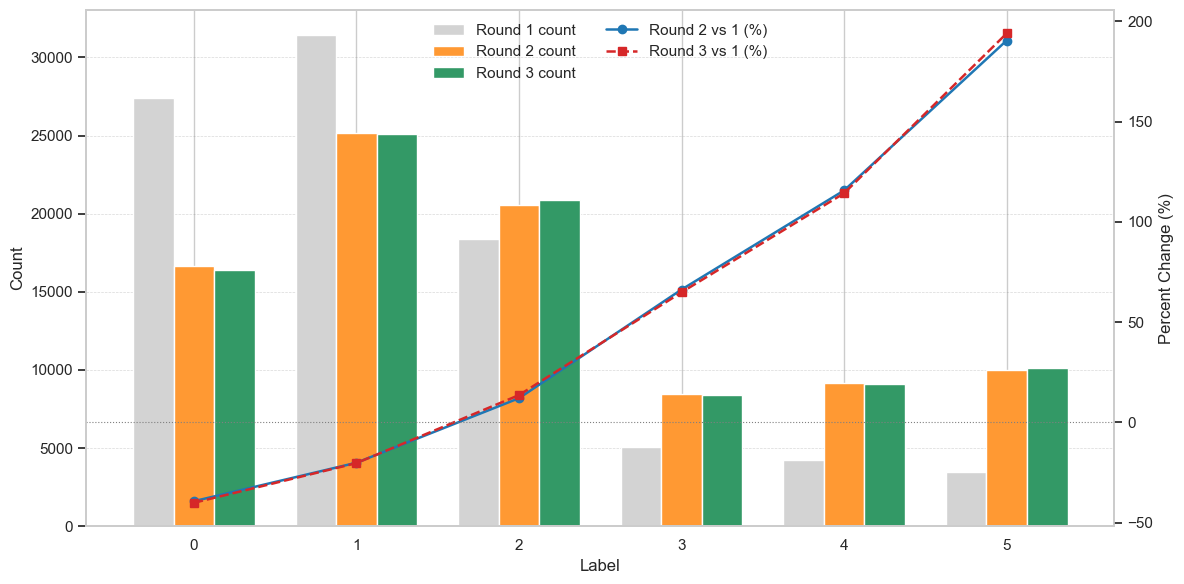

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FIRST_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/synthetic_training_data_user.csv"
SECOND_PATH = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/second_round_interactions_5000_v2.csv"
THIRD_PATH  = "/Users/cailingchen/Desktop/Final Project/Synthetic Data/third_round_interactions_5000_v3.csv"
df1 = pd.read_csv(FIRST_PATH)
df2 = pd.read_csv(SECOND_PATH)
df3 = pd.read_csv(THIRD_PATH)

dist1 = df1['label'].value_counts().sort_index()
dist2 = df2['label'].value_counts().sort_index()
dist3 = df3['label'].value_counts().sort_index()

df_compare = pd.DataFrame({
    'Round 1': dist1,
    'Round 2': dist2,
    'Round 3': dist3
}).fillna(0).astype(int)

pct2 = (df_compare['Round 2'] - df_compare['Round 1']) / df_compare['Round 1'] * 100
pct3 = (df_compare['Round 3'] - df_compare['Round 1']) / df_compare['Round 1'] * 100

labels = df_compare.index.astype(str).tolist()
x = np.arange(len(labels))
bar_w = 0.25

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bar chart
ax1.bar(x - bar_w, df_compare['Round 1'], bar_w, label='Round 1 count', color='lightgray')
ax1.bar(x        , df_compare['Round 2'], bar_w, label='Round 2 count', color='#FF9933')
ax1.bar(x + bar_w, df_compare['Round 3'], bar_w, label='Round 3 count', color='#339966')

ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Light grid lines
ax1.grid(True, axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Line plot on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(x, pct2, marker='o', linestyle='-', color='tab:blue', label='Round 2 vs 1 (%)', linewidth=1.8)
ax2.plot(x, pct3, marker='s', linestyle='--', color='tab:red', label='Round 3 vs 1 (%)', linewidth=1.8)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')  # neutral reference line
ax2.set_ylabel('Percent Change (%)')
ax2.grid(False)  # remove y2 grid

# Combine legends from both axes
bars, bar_labels = ax1.get_legend_handles_labels()
lines, line_labels = ax2.get_legend_handles_labels()
ax1.legend(bars + lines, bar_labels + line_labels, loc='upper center', ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("/Users/cailingchen/Desktop/Final Project/Plots/Iteration Evaluation - Label Counts and Percent Changes.pdf")

plt.show()
